# Assignment 4: Unsupervised Learning - Part 1
## Implementation from Scratch

This notebook implements four unsupervised learning algorithms from scratch using only NumPy:
1. Principal Component Analysis (PCA)
2. Autoencoders
3. K-Means Clustering
4. Gaussian Mixture Models (GMM)

**Dataset**: Breast Cancer Wisconsin (Diagnostic) Dataset


## Part 0: Data Loading and Preprocessing

Before implementing our algorithms, we need to:
1. Load the breast cancer dataset
2. Handle missing values
3. Normalize/standardize the data

**Why normalization is important**: 
- PCA works best when features are on the same scale
- Neural networks (autoencoders) require normalized inputs for stable training
- Clustering algorithms are sensitive to feature scales


In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [121]:
# Load the dataset
df = pd.read_csv('data.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())
print("\nMissing values per column:")
missing_per_col = df.isnull().sum()
print(missing_per_col)

# Check for columns with all NaN values (like 'Unnamed: 32')
all_nan_cols = missing_per_col[missing_per_col == len(df)].index.tolist()
if all_nan_cols:
    print(f"\nWarning: Columns with all NaN values: {all_nan_cols}")
    print("These will be excluded from features.")


Dataset shape: (569, 33)

First few rows:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_wors

In [122]:
# Separate features and labels
# We'll use labels only for evaluation later, not for training (unsupervised learning)

# Get feature columns (exclude 'id', 'diagnosis', and any columns with all NaN)
feature_columns = [col for col in df.columns 
                   if col not in ['id', 'diagnosis'] 
                   and not df[col].isnull().all()]

# Extract features and labels
X = df[feature_columns].values
y = df['diagnosis'].values

# Convert labels to binary for later evaluation (M=1, B=0)
y_binary = (y == 'M').astype(int)

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"\nClass distribution:")
print(f"  Malignant (M): {np.sum(y_binary)}")
print(f"  Benign (B): {np.sum(1 - y_binary)}")
print(f"\nFeature columns used: {len(feature_columns)}")


Feature matrix shape: (569, 30)
Number of features: 30
Number of samples: 569

Class distribution:
  Malignant (M): 212
  Benign (B): 357

Feature columns used: 30


In [123]:
# Handle missing values
# Check if there are any missing values in the feature columns
missing_count = df[feature_columns].isnull().sum().sum()
print(f"Total missing values in features: {missing_count}")

if missing_count > 0:
    # Fill missing values with column mean
    X_df = pd.DataFrame(X, columns=feature_columns)
    X = X_df.fillna(X_df.mean()).values
    print("Missing values filled with column means")
else:
    print("No missing values found")

# Verify no NaN values remain
if np.isnan(X).any():
    print("WARNING: X still contains NaN values after filling!")
    print(f"NaN count: {np.isnan(X).sum()}")
else:
    print("Confirmed: No NaN values in X")


Total missing values in features: 0
No missing values found
Confirmed: No NaN values in X


In [124]:
# Normalize/Standardize the data
# Standardization: (x - mean) / std
# This ensures mean=0 and std=1 for each feature

# Check for NaN before normalization
if np.isnan(X).any():
    raise ValueError("X contains NaN values before normalization. Please handle missing values first.")

X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)

# Check for NaN in mean or std (shouldn't happen if X has no NaN)
if np.isnan(X_mean).any() or np.isnan(X_std).any():
    print("WARNING: Mean or std contains NaN!")
    print(f"NaN in mean: {np.isnan(X_mean).sum()}")
    print(f"NaN in std: {np.isnan(X_std).sum()}")

# Avoid division by zero for features with zero variance
X_std[X_std == 0] = 1

# Standardize
X_normalized = (X - X_mean) / X_std

# Check for NaN after normalization
if np.isnan(X_normalized).any():
    print("WARNING: X_normalized contains NaN after normalization!")
    print(f"NaN count: {np.isnan(X_normalized).sum()}")
else:
    print("Confirmed: No NaN values in X_normalized")

# Verify normalization
print("\nNormalization verification:")
print(f"  Mean of normalized data (should be ~0): {np.mean(X_normalized, axis=0)[:5]}")
print(f"  Std of normalized data (should be ~1): {np.std(X_normalized, axis=0)[:5]}")
print(f"\nNormalized data shape: {X_normalized.shape}")

# Store original statistics for potential inverse operations
X_original_mean = X_mean
X_original_std = X_std


Confirmed: No NaN values in X_normalized

Normalization verification:
  Mean of normalized data (should be ~0): [-1.37363271e-16  6.86816353e-17 -1.24875700e-16 -2.18532476e-16
 -8.36667193e-16]
  Std of normalized data (should be ~1): [1. 1. 1. 1. 1.]

Normalized data shape: (569, 30)


## Part 1: Implementation from Scratch

### 1. Principal Component Analysis (PCA)

**What is PCA?**
PCA is a dimensionality reduction technique that finds the directions (principal components) of maximum variance in the data and projects the data onto these directions.

**Key Concepts:**
- **Eigenvalue Decomposition**: We decompose the covariance matrix to find principal components (eigenvectors) and their importance (eigenvalues)
- **Explained Variance Ratio**: Shows what percentage of total variance each component captures
- **Reconstruction Error**: Measures how much information is lost when reducing dimensions
- **Inverse Transform**: Reconstructs the original data from the reduced representation (with some loss)

**Inverse Transform Explained**: 
If you reduce 31D data to 2D using PCA, inverse transform takes those 2D points and projects them back to 31D space. However, since information was lost during reduction, the reconstructed data won't be identical to the original - this is the reconstruction error.


In [125]:
class PCA:
    """
    Principal Component Analysis implementation from scratch using NumPy.
    
    Algorithm:
    1. Center the data (subtract mean)
    2. Compute covariance matrix: C = (1/n) * X^T * X
    3. Perform eigenvalue decomposition: C = V * Λ * V^T
    4. Select top k eigenvectors (principal components)
    5. Project data: Y = X * V_k
    6. Reconstruct: X_recon = Y * V_k^T + mean
    """
    
    def __init__(self, n_components=None):
        """
        Parameters:
        -----------
        n_components : int, optional
            Number of principal components to keep. If None, keeps all components.
        """
        self.n_components = n_components
        self.components_ = None  # Principal components (eigenvectors)
        self.mean_ = None  # Mean of training data
        self.explained_variance_ = None  # Eigenvalues (variance explained by each component)
        self.explained_variance_ratio_ = None  # Percentage of variance explained
        
    def fit(self, X):
        """
        Fit PCA on the data.
        
        Parameters:
        -----------
        X : ndarray of shape (n_samples, n_features)
            Training data
        """
        # Check for NaN or Inf values
        if np.isnan(X).any() or np.isinf(X).any():
            raise ValueError("Input data contains NaN or Inf values")
        
        # Center the data by subtracting mean
        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_
        
        # Compute covariance matrix
        # Formula: C = (1/(n-1)) * X^T * X
        n_samples = X.shape[0]
        cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)
        
        # Check for NaN or Inf in covariance matrix
        if np.isnan(cov_matrix).any() or np.isinf(cov_matrix).any():
            raise ValueError("Covariance matrix contains NaN or Inf values")
        
        # Eigenvalue decomposition
        # This finds eigenvectors (principal components) and eigenvalues (variance)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # Filter out negative eigenvalues (due to numerical errors)
        # Covariance matrices should be positive semi-definite
        eigenvalues = np.maximum(eigenvalues, 0)
        
        # Sort eigenvalues and eigenvectors in descending order
        # (largest eigenvalue = most important component)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Determine number of components
        if self.n_components is None:
            self.n_components = min(X.shape[0], X.shape[1])
        
        # Store principal components (top k eigenvectors)
        self.components_ = eigenvectors[:, :self.n_components].T
        
        # Store explained variance
        self.explained_variance_ = eigenvalues[:self.n_components]
        
        # Explained variance ratio = variance of component / total variance
        # Handle division by zero: if sum is zero, set ratio to zero
        total_variance = np.sum(eigenvalues)
        if total_variance > 0:
            self.explained_variance_ratio_ = self.explained_variance_ / total_variance
        else:
            # If total variance is zero, all ratios are zero
            self.explained_variance_ratio_ = np.zeros(self.n_components)
        
        return self
    
    def transform(self, X):
        """
        Apply dimensionality reduction to X.
        
        Parameters:
        -----------
        X : ndarray of shape (n_samples, n_features)
            Data to transform
            
        Returns:
        --------
        X_transformed : ndarray of shape (n_samples, n_components)
            Transformed data in reduced space
        """
        # Center the data
        X_centered = X - self.mean_
        # Project onto principal components
        return np.dot(X_centered, self.components_.T)
    
    def inverse_transform(self, X_transformed):
        """
        Transform data back to original space.
        
        This reconstructs the original data from the reduced representation.
        Note: Some information is lost, so reconstruction won't be perfect.
        
        Parameters:
        -----------
        X_transformed : ndarray of shape (n_samples, n_components)
            Data in reduced space
            
        Returns:
        --------
        X_reconstructed : ndarray of shape (n_samples, n_features)
            Reconstructed data in original space
        """
        # Project back: X_recon = X_reduced * components + mean
        X_reconstructed = np.dot(X_transformed, self.components_) + self.mean_
        return X_reconstructed
    
    def fit_transform(self, X):
        """
        Fit the model and transform the data.
        
        Parameters:
        -----------
        X : ndarray of shape (n_samples, n_features)
            Training data
            
        Returns:
        --------
        X_transformed : ndarray of shape (n_samples, n_components)
            Transformed data
        """
        return self.fit(X).transform(X)
    
    def reconstruction_error(self, X):
        """
        Compute reconstruction error (Mean Squared Error).
        
        This measures how much information is lost during dimensionality reduction.
        
        Parameters:
        -----------
        X : ndarray of shape (n_samples, n_features)
            Original data
            
        Returns:
        --------
        error : float
            Mean squared reconstruction error
        """
        # Transform to reduced space
        X_transformed = self.transform(X)
        # Reconstruct back to original space
        X_reconstructed = self.inverse_transform(X_transformed)
        # Compute MSE
        mse = np.mean((X - X_reconstructed) ** 2)
        return mse


### 2. Autoencoder

**What is an Autoencoder?**
An autoencoder is a neural network that learns to compress data into a lower-dimensional representation (encoding) and then reconstruct it back. It consists of:
- **Encoder**: Compresses input to bottleneck (latent representation)
- **Decoder**: Reconstructs input from bottleneck

**Key Concepts:**
- **Backpropagation**: Algorithm to compute gradients and update weights by propagating error backward through the network
- **Mini-batch Gradient Descent**: Updates weights using small batches instead of entire dataset (faster, more stable than full batch)
- **Learning Rate Scheduling**: Gradually reducing learning rate during training to help convergence (starts fast, slows down)
- **L2 Regularization**: Penalizes large weights to prevent overfitting

**Learning Rate Scheduling Explained**: 
Instead of using a fixed learning rate throughout training, we reduce it over time. For example, multiply by 0.95 every 10 epochs. This helps because: early training uses larger steps to make progress quickly, later training uses smaller steps for fine-tuning and stable convergence.


In [126]:
class Autoencoder:
    """
    Fully connected Autoencoder implementation from scratch using NumPy.
    
    Architecture:
    - Encoder: Input → Hidden1 → Hidden2 → Hidden3 → Bottleneck
    - Decoder: Bottleneck → Hidden3 → Hidden2 → Hidden1 → Output
    
    Features:
    - Multiple activation functions (ReLU, sigmoid, tanh)
    - Backpropagation from scratch
    - Mini-batch gradient descent
    - Learning rate scheduling
    - L2 regularization
    """
    
    def __init__(self, input_dim, encoding_dim, hidden_dims=[64, 32, 16], 
                 activation='relu', learning_rate=0.001, l2_reg=0.0001,
                 batch_size=32, max_epochs=100, tol=1e-6, verbose=True):
        """
        Parameters:
        -----------
        input_dim : int
            Dimension of input data
        encoding_dim : int
            Dimension of bottleneck (latent space)
        hidden_dims : list
            List of hidden layer dimensions for encoder (decoder is reversed)
        activation : str
            Activation function: 'relu', 'sigmoid', or 'tanh'
        learning_rate : float
            Initial learning rate (will be scheduled)
        l2_reg : float
            L2 regularization coefficient
        batch_size : int
            Mini-batch size for gradient descent
        max_epochs : int
            Maximum number of training epochs
        tol : float
            Convergence tolerance
        verbose : bool
            Whether to print training progress
        """
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.hidden_dims = hidden_dims
        self.activation = activation
        self.learning_rate = learning_rate
        self.l2_reg = l2_reg
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.tol = tol
        self.verbose = verbose
        
        # Build architecture
        # Encoder: input -> hidden1 -> hidden2 -> hidden3 -> encoding
        # Decoder: encoding -> hidden3 -> hidden2 -> hidden1 -> output
        self.encoder_dims = [input_dim] + hidden_dims + [encoding_dim]
        self.decoder_dims = [encoding_dim] + hidden_dims[::-1] + [input_dim]
        
        # Initialize weights and biases
        self.weights = []
        self.biases = []
        self.initialize_weights()
        
        # Training history
        self.loss_history = []
        
    def initialize_weights(self):
        """
        Initialize weights using Xavier/Glorot initialization.
        This helps with gradient flow during training.
        """
        # Encoder weights
        for i in range(len(self.encoder_dims) - 1):
            # Xavier initialization: uniform distribution in [-limit, limit]
            limit = np.sqrt(6.0 / (self.encoder_dims[i] + self.encoder_dims[i+1]))
            w = np.random.uniform(-limit, limit, (self.encoder_dims[i], self.encoder_dims[i+1]))
            b = np.zeros((1, self.encoder_dims[i+1]))
            self.weights.append(w)
            self.biases.append(b)
        
        # Decoder weights (symmetric structure)
        for i in range(len(self.decoder_dims) - 1):
            limit = np.sqrt(6.0 / (self.decoder_dims[i] + self.decoder_dims[i+1]))
            w = np.random.uniform(-limit, limit, (self.decoder_dims[i], self.decoder_dims[i+1]))
            b = np.zeros((1, self.decoder_dims[i+1]))
            self.weights.append(w)
            self.biases.append(b)
    
    def activation_fn(self, x):
        """Apply activation function."""
        if self.activation == 'relu':
            return np.maximum(0, x)  # ReLU: max(0, x)
        elif self.activation == 'sigmoid':
            # Clip to avoid overflow
            return 1 / (1 + np.exp(-np.clip(x, -250, 250)))
        elif self.activation == 'tanh':
            return np.tanh(x)
        else:
            raise ValueError(f"Unknown activation: {self.activation}")
    
    def activation_derivative(self, x):
        """
        Compute derivative of activation function.
        Needed for backpropagation.
        """
        if self.activation == 'relu':
            return (x > 0).astype(float)  # 1 if x > 0, else 0
        elif self.activation == 'sigmoid':
            s = self.activation_fn(x)
            return s * (1 - s)  # sigmoid'(x) = sigmoid(x) * (1 - sigmoid(x))
        elif self.activation == 'tanh':
            return 1 - np.tanh(x) ** 2  # tanh'(x) = 1 - tanh²(x)
        else:
            raise ValueError(f"Unknown activation: {self.activation}")
    
    def forward(self, X):
        """
        Forward pass through the network.
        
        Returns:
        --------
        activations : list
            Activations at each layer
        z_values : list
            Pre-activation values (z = Wx + b) at each layer
        """
        activations = [X]  # Input layer
        z_values = []
        
        # Encoder forward pass
        current = X
        for i in range(len(self.encoder_dims) - 1):
            # Linear transformation: z = Wx + b
            z = np.dot(current, self.weights[i]) + self.biases[i]
            z_values.append(z)
            # Apply activation (except last encoder layer - bottleneck)
            if i < len(self.encoder_dims) - 2:
                current = self.activation_fn(z)
            else:
                current = z  # Bottleneck: no activation
            activations.append(current)
        
        # Decoder forward pass
        for i in range(len(self.decoder_dims) - 1):
            idx = len(self.encoder_dims) - 1 + i
            z = np.dot(current, self.weights[idx]) + self.biases[idx]
            z_values.append(z)
            # Apply activation (except last decoder layer - output)
            if i < len(self.decoder_dims) - 2:
                current = self.activation_fn(z)
            else:
                current = z  # Output: no activation
            activations.append(current)
        
        return activations, z_values
    
    def backward(self, X, activations, z_values, output):
        """
        Backward pass (backpropagation).
        
        Computes gradients of loss with respect to weights and biases.
        
        Structure (example with encoder_dims=[31,32,16,10], decoder_dims=[10,16,32,31]):
        - activations: [X(31), a0(32), a1(16), bottleneck(10), d0(16), d1(32), output(31)]
          indices:      [0,     1,      2,       3,            4,      5,       6]
        - z_values: [z0(32), z1(16), z2(10), dz0(16), dz1(32), dz2(31)]
          indices:  [0,      1,      2,      3,       4,       5]
        - weights: [W0(31->32), W1(32->16), W2(16->10), dW0(10->16), dW1(16->32), dW2(32->31)]
          indices: [0,           1,           2,           3,           4,           5]
        """
        n_samples = X.shape[0]
        
        # Compute output error (derivative of MSE loss)
        error = output - X
        
        # Initialize gradients
        weight_grads = [np.zeros_like(w) for w in self.weights]
        bias_grads = [np.zeros_like(b) for b in self.biases]
        
        # Number of encoder and decoder layers
        n_encoder_layers = len(self.encoder_dims) - 1
        n_decoder_layers = len(self.decoder_dims) - 1
        
        # ========== BACKPROPAGATE THROUGH DECODER ==========
        # Start with error at output
        delta = error  # Shape: (batch_size, output_dim)
        
        # Process decoder layers in reverse order: output -> middle -> bottleneck
        for i in range(n_decoder_layers - 1, -1, -1):
            # Weight index: decoder weights start after encoder weights
            weight_idx = n_encoder_layers + i
            
            # Input activation index for this decoder layer
            # Decoder layer i takes input from activations[n_encoder_layers + i]
            act_input_idx = n_encoder_layers + i
            
            # Compute gradients
            weight_grads[weight_idx] = np.dot(activations[act_input_idx].T, delta) / n_samples
            bias_grads[weight_idx] = np.mean(delta, axis=0, keepdims=True)
            
            # Propagate error backward to previous layer
            # For decoder layer i, we propagate to get error at input of this layer
            # This is the output of the previous layer (or bottleneck for i=0)
            if i > 0:
                # For middle/output layers: propagate through weight and apply activation derivative
                # Propagate through weight matrix: delta = delta @ W^T
                # weights[weight_idx] has shape (input_dim, output_dim) = (decoder_dims[i], decoder_dims[i+1])
                # So weights[weight_idx].T has shape (decoder_dims[i+1], decoder_dims[i])
                # delta @ weights[weight_idx].T: (batch, decoder_dims[i+1]) @ (decoder_dims[i+1], decoder_dims[i])
                # = (batch, decoder_dims[i])
                delta = np.dot(delta, self.weights[weight_idx].T)
                # Apply activation derivative
                # z_value index: decoder z_values start after encoder z_values
                # z_values[n_encoder_layers + i - 1] corresponds to decoder layer i-1 output
                z_idx = n_encoder_layers + i - 1
                delta *= self.activation_derivative(z_values[z_idx])
            else:
                # For first decoder layer (i=0): propagate to bottleneck (no activation derivative)
                # This layer connects bottleneck to first decoder hidden layer
                # Propagate through weight matrix: delta = delta @ W^T
                # weights[weight_idx] has shape (decoder_dims[0], decoder_dims[1]) = (encoding_dim, first_hidden)
                # So weights[weight_idx].T has shape (decoder_dims[1], decoder_dims[0])
                # delta @ weights[weight_idx].T: (batch, decoder_dims[1]) @ (decoder_dims[1], decoder_dims[0])
                # = (batch, decoder_dims[0]) = (batch, encoding_dim)
                delta = np.dot(delta, self.weights[weight_idx].T)
                # No activation derivative because bottleneck has no activation
        
        # After decoder backprop, delta is error at bottleneck
        # ========== BACKPROPAGATE THROUGH ENCODER ==========
        # Process encoder layers in reverse order: bottleneck -> middle -> input
        for i in range(n_encoder_layers - 1, -1, -1):
            # Weight index: encoder weights are first
            weight_idx = i
            
            # Input activation index for this encoder layer
            # Encoder layer i takes input from activations[i]
            act_input_idx = i
            
            # Compute gradients
            weight_grads[weight_idx] = np.dot(activations[act_input_idx].T, delta) / n_samples
            bias_grads[weight_idx] = np.mean(delta, axis=0, keepdims=True)
            
            # Propagate error backward (except for first encoder layer connecting to input)
            if i > 0:
                # Propagate through weight matrix: delta = delta @ W^T
                # weights[i] has shape (input_dim, output_dim) = (encoder_dims[i], encoder_dims[i+1])
                # So weights[i].T has shape (encoder_dims[i+1], encoder_dims[i])
                # delta @ weights[i].T: (batch, encoder_dims[i+1]) @ (encoder_dims[i+1], encoder_dims[i])
                # = (batch, encoder_dims[i])
                delta = np.dot(delta, self.weights[weight_idx].T)
                # Apply activation derivative
                # z_value index: encoder z_values are first
                # z_values[i-1] corresponds to the output of encoder layer i-1
                z_idx = i - 1
                delta *= self.activation_derivative(z_values[z_idx])
        
        return weight_grads, bias_grads
    
    def compute_loss(self, X, output):
        """
        Compute reconstruction loss with L2 regularization.
        
        Loss = MSE + L2_regularization
        """
        # Reconstruction loss (MSE)
        reconstruction_loss = np.mean((X - output) ** 2)
        
        # L2 regularization: penalize large weights
        l2_loss = 0
        for w in self.weights:
            l2_loss += np.sum(w ** 2)
        l2_loss = self.l2_reg * l2_loss
        
        return reconstruction_loss + l2_loss
    
    def fit(self, X):
        """
        Train the autoencoder using mini-batch gradient descent.
        """
        n_samples = X.shape[0]
        n_batches = int(np.ceil(n_samples / self.batch_size))
        
        prev_loss = float('inf')
        
        for epoch in range(self.max_epochs):
            # Shuffle data for each epoch
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            
            epoch_loss = 0
            
            # Mini-batch training
            for batch_idx in range(n_batches):
                # Get batch
                start_idx = batch_idx * self.batch_size
                end_idx = min((batch_idx + 1) * self.batch_size, n_samples)
                X_batch = X_shuffled[start_idx:end_idx]
                
                # Forward pass
                activations, z_values = self.forward(X_batch)
                output = activations[-1]
                
                # Compute loss
                batch_loss = self.compute_loss(X_batch, output)
                epoch_loss += batch_loss
                
                # Backward pass
                weight_grads, bias_grads = self.backward(X_batch, activations, z_values, output)
                
                # Learning rate scheduling: reduce LR every 10 epochs
                lr = self.learning_rate * (0.95 ** (epoch // 10))
                
                # Update weights with L2 regularization
                for i in range(len(self.weights)):
                    # Add L2 regularization to gradient
                    weight_grads[i] += self.l2_reg * self.weights[i]
                    # Gradient descent update
                    self.weights[i] -= lr * weight_grads[i]
                    self.biases[i] -= lr * bias_grads[i]
            
            epoch_loss /= n_batches
            self.loss_history.append(epoch_loss)
            
            # Check convergence
            if abs(prev_loss - epoch_loss) < self.tol:
                if self.verbose:
                    print(f"Converged at epoch {epoch+1}")
                break
            
            prev_loss = epoch_loss
            
            if self.verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{self.max_epochs}, Loss: {epoch_loss:.6f}")
        
        return self
    
    def encode(self, X):
        """Encode input to latent representation."""
        current = X
        for i in range(len(self.encoder_dims) - 1):
            z = np.dot(current, self.weights[i]) + self.biases[i]
            if i < len(self.encoder_dims) - 2:
                current = self.activation_fn(z)
            else:
                current = z  # Bottleneck: no activation
        return current
    
    def decode(self, encoded):
        """Decode latent representation to output."""
        current = encoded
        for i in range(len(self.decoder_dims) - 1):
            idx = len(self.encoder_dims) - 1 + i
            z = np.dot(current, self.weights[idx]) + self.biases[idx]
            if i < len(self.decoder_dims) - 2:
                current = self.activation_fn(z)
            else:
                current = z  # Output: no activation
        return current
    
    def transform(self, X):
        """Transform data to latent space."""
        return self.encode(X)
    
    def inverse_transform(self, encoded):
        """Reconstruct data from latent space."""
        return self.decode(encoded)
    
    def fit_transform(self, X):
        """Fit and transform."""
        return self.fit(X).transform(X)
    
    def reconstruction_error(self, X):
        """Compute reconstruction error."""
        encoded = self.encode(X)
        reconstructed = self.decode(encoded)
        return np.mean((X - reconstructed) ** 2)


### 3. K-Means Clustering

**What is K-Means?**
K-Means partitions data into k clusters by minimizing the sum of squared distances from points to their cluster centroids.

**Key Concepts:**
- **K-Means++ Initialization**: Smart initialization that spreads initial centroids far apart
- **Random Initialization**: Traditional method - randomly select k points as centroids
- **Inertia**: Within-cluster sum of squares (WCSS) - measures how tight clusters are
- **Convergence**: Algorithm stops when centroids stop moving significantly

**K-Means++ Explained**: 
Instead of randomly picking k points, K-Means++:
1. Picks first centroid randomly
2. For each remaining centroid, picks a point with probability proportional to squared distance from nearest existing centroid
This gives better initial centroids (spread out) and faster convergence compared to random initialization.

**Inertia Explained**: 
Inertia = sum of squared distances from each point to its assigned centroid. Lower inertia = tighter clusters. We track this over iterations to see convergence - it should decrease and stabilize as the algorithm converges.


In [127]:
class KMeans:
    """
    K-Means clustering implementation from scratch using NumPy.
    
    Algorithm:
    1. Initialize centroids (K-Means++ or random)
    2. Assign points to nearest centroid
    3. Update centroids to mean of assigned points
    4. Repeat until convergence
    
    Features:
    - K-Means++ initialization
    - Random initialization for comparison
    - Convergence criteria (tolerance-based)
    - Inertia tracking
    """
    
    def __init__(self, n_clusters=8, init='kmeans++', max_iter=300, tol=1e-4, random_state=None):
        """
        Parameters:
        -----------
        n_clusters : int
            Number of clusters
        init : str
            Initialization method: 'kmeans++' or 'random'
        max_iter : int
            Maximum number of iterations
        tol : float
            Tolerance for convergence (centroid shift threshold)
        random_state : int
            Random seed
        """
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids_ = None  # Cluster centroids
        self.labels_ = None  # Cluster assignments
        self.inertia_ = None  # Final inertia (WCSS)
        self.inertia_history_ = []  # Inertia at each iteration
        
        if random_state is not None:
            np.random.seed(random_state)
    
    def _kmeans_plus_plus_init(self, X):
        """
        K-Means++ initialization.
        
        This method spreads initial centroids far apart, leading to better clustering.
        """
        n_samples, n_features = X.shape
        centroids = np.zeros((self.n_clusters, n_features))
        
        # First centroid: random point
        centroids[0] = X[np.random.randint(n_samples)]
        
        # Remaining centroids: choose points with probability proportional to distance^2
        for i in range(1, self.n_clusters):
            # Compute distances to nearest existing centroid for each point
            distances = np.array([
                min([np.sum((x - c)**2) for c in centroids[:i]]) 
                for x in X
            ])
            
            # Convert distances to probabilities
            probabilities = distances / distances.sum()
            
            # Choose next centroid using cumulative probabilities
            cumulative_probs = probabilities.cumsum()
            r = np.random.rand()
            idx = np.searchsorted(cumulative_probs, r)
            centroids[i] = X[idx]
        
        return centroids
    
    def _random_init(self, X):
        """Random initialization: randomly select k points as centroids."""
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        return X[indices]
    
    def _assign_clusters(self, X):
        """
        Assign points to nearest centroid.
        
        Returns:
        --------
        labels : ndarray
            Cluster assignment for each point
        """
        # Compute distances from each point to each centroid
        # Shape: (n_samples, n_clusters)
        distances = np.sqrt(
            ((X[:, np.newaxis, :] - self.centroids_[np.newaxis, :, :]) ** 2).sum(axis=2)
        )
        # Assign to nearest centroid
        return np.argmin(distances, axis=1)
    
    def _update_centroids(self, X, labels):
        """
        Update centroids to mean of assigned points.
        """
        new_centroids = np.zeros_like(self.centroids_)
        for k in range(self.n_clusters):
            mask = labels == k
            if mask.sum() > 0:
                # New centroid = mean of points in cluster
                new_centroids[k] = X[mask].mean(axis=0)
            else:
                # If cluster is empty, keep old centroid
                new_centroids[k] = self.centroids_[k]
        return new_centroids
    
    def _compute_inertia(self, X, labels):
        """
        Compute within-cluster sum of squares (inertia/WCSS).
        
        Inertia = sum of squared distances from each point to its centroid.
        Lower inertia = tighter clusters.
        """
        inertia = 0
        for k in range(self.n_clusters):
            mask = labels == k
            if mask.sum() > 0:
                # Sum of squared distances in cluster k
                inertia += np.sum((X[mask] - self.centroids_[k]) ** 2)
        return inertia
    
    def fit(self, X):
        """
        Fit K-Means to the data.
        """
        # Initialize centroids
        if self.init == 'kmeans++':
            self.centroids_ = self._kmeans_plus_plus_init(X)
        else:
            self.centroids_ = self._random_init(X)
        
        # Iterate until convergence
        for iteration in range(self.max_iter):
            # Assign points to clusters
            labels = self._assign_clusters(X)
            
            # Compute inertia
            inertia = self._compute_inertia(X, labels)
            self.inertia_history_.append(inertia)
            
            # Update centroids
            new_centroids = self._update_centroids(X, labels)
            
            # Check convergence: stop if centroids don't move much
            centroid_shift = np.sqrt(
                ((new_centroids - self.centroids_) ** 2).sum(axis=1)
            ).max()
            
            if centroid_shift < self.tol:
                break
            
            self.centroids_ = new_centroids
        
        self.labels_ = labels
        self.inertia_ = inertia
        
        return self
    
    def predict(self, X):
        """Predict cluster labels for new data."""
        return self._assign_clusters(X)
    
    def fit_predict(self, X):
        """Fit and predict."""
        return self.fit(X).labels_


### 4. Gaussian Mixture Models (GMM)

**What is GMM?**
GMM models data as a mixture of multiple Gaussian distributions. Each cluster is represented by a Gaussian with its own mean and covariance.

**Key Concepts:**
- **EM Algorithm**: Expectation-Maximization algorithm for fitting GMM
  - E-step: Compute responsibilities (probability each point belongs to each component)
  - M-step: Update parameters (means, covariances, weights) based on responsibilities
- **Covariance Types**: Different ways to model cluster shapes
  - **Full**: Each component has its own full covariance matrix (most flexible, can be elliptical in any direction)
  - **Tied**: All components share the same covariance matrix (same shape and orientation, different locations)
  - **Diagonal**: Each component has diagonal covariance (features are independent, axis-aligned ellipses)
  - **Spherical**: Each component has spherical covariance (circular/spherical clusters, same variance in all directions)
- **Log-likelihood**: Measures how well the model fits the data (higher is better)
- **Numerical Stability**: Handling edge cases to avoid errors (singular matrices, division by zero, overflow)

**Covariance Types Explained**:
- **Full**: Most flexible - each cluster can be an ellipse oriented in any direction (most parameters)
- **Tied**: All clusters have the same shape and orientation, just different locations (fewer parameters)
- **Diagonal**: Clusters are axis-aligned ellipses (no rotation, features independent)
- **Spherical**: Clusters are circles/spheres (same variance in all directions, simplest)

**Numerical Stability**: We add small regularization to covariance matrices, use Cholesky decomposition, and handle singular matrices with pseudo-inverse to prevent crashes.


In [128]:
class GaussianMixture:
    """
    Gaussian Mixture Model implementation from scratch using NumPy.
    
    Implements EM algorithm with support for different covariance types.
    
    EM Algorithm:
    1. E-step: Compute responsibilities (posterior probabilities)
    2. M-step: Update parameters (means, covariances, weights)
    3. Repeat until convergence
    """
    
    def __init__(self, n_components=1, covariance_type='full', max_iter=100, 
                 tol=1e-3, reg_covar=1e-6, random_state=None):
        """
        Parameters:
        -----------
        n_components : int
            Number of mixture components
        covariance_type : str
            Type of covariance: 'full', 'tied', 'diag', 'spherical'
        max_iter : int
            Maximum number of EM iterations
        tol : float
            Convergence tolerance (log-likelihood change threshold)
        reg_covar : float
            Regularization added to diagonal of covariance matrices (for numerical stability)
        random_state : int
            Random seed
        """
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar  # Prevents singular matrices
        self.random_state = random_state
        
        self.weights_ = None  # Mixing weights (π_k)
        self.means_ = None  # Component means (μ_k)
        self.covariances_ = None  # Component covariances (Σ_k)
        self.log_likelihood_history_ = []  # Log-likelihood at each iteration
        
        if random_state is not None:
            np.random.seed(random_state)
    
    def _initialize_parameters(self, X):
        """
        Initialize GMM parameters.
        """
        n_samples, n_features = X.shape
        
        # Initialize weights (equal for all components)
        self.weights_ = np.ones(self.n_components) / self.n_components
        
        # Initialize means (random data points)
        indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means_ = X[indices].copy()
        
        # Initialize covariances based on type
        if self.covariance_type == 'full':
            # Each component has its own full covariance matrix
            self.covariances_ = np.array([np.eye(n_features) for _ in range(self.n_components)])
        elif self.covariance_type == 'tied':
            # All components share the same covariance matrix
            self.covariances_ = np.eye(n_features)
        elif self.covariance_type == 'diag':
            # Each component has diagonal covariance (vector)
            self.covariances_ = np.ones((self.n_components, n_features))
        elif self.covariance_type == 'spherical':
            # Each component has spherical covariance (scalar)
            self.covariances_ = np.ones(self.n_components)
        else:
            raise ValueError(f"Unknown covariance type: {self.covariance_type}")
    
    def _compute_log_prob(self, X):
        """
        Compute log probability for each component.
        
        Returns log P(x|component_k) for each point and component.
        """
        n_samples, n_features = X.shape
        log_prob = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            # Compute difference from mean
            diff = X - self.means_[k]
            
            # Get covariance matrix based on type
            if self.covariance_type == 'full':
                cov = self.covariances_[k]
            elif self.covariance_type == 'tied':
                cov = self.covariances_
            elif self.covariance_type == 'diag':
                cov = np.diag(self.covariances_[k])
            elif self.covariance_type == 'spherical':
                cov = self.covariances_[k] * np.eye(n_features)
            
            # Add regularization for numerical stability
            cov += self.reg_covar * np.eye(n_features)
            
            # Compute log probability using multivariate Gaussian formula
            try:
                # Cholesky decomposition for numerical stability
                L = np.linalg.cholesky(cov)
                log_det = 2 * np.sum(np.log(np.diag(L)))
                inv_cov = np.linalg.solve(L, np.eye(n_features))
                inv_cov = np.dot(inv_cov.T, inv_cov)
            except np.linalg.LinAlgError:
                # If Cholesky fails, use pseudo-inverse (numerical stability)
                inv_cov = np.linalg.pinv(cov)
                log_det = np.linalg.slogdet(cov)[1]
            
            # Mahalanobis distance: (x - μ)^T * Σ^(-1) * (x - μ)
            mahal = np.sum(diff @ inv_cov * diff, axis=1)
            
            # Log probability: -0.5 * (d*log(2π) + log|Σ| + Mahalanobis)
            log_prob[:, k] = -0.5 * (n_features * np.log(2 * np.pi) + log_det + mahal)
        
        return log_prob
    
    def _e_step(self, X):
        """
        E-step: Compute responsibilities (posterior probabilities).
        
        Responsibility = P(component_k | x) = P(x | component_k) * P(component_k) / P(x)
        """
        # Compute log probabilities
        log_prob = self._compute_log_prob(X)
        
        # Add log weights: log P(x|k) + log π_k
        weighted_log_prob = log_prob + np.log(self.weights_ + 1e-10)
        
        # Compute log-sum-exp for numerical stability
        # log(sum(exp(log_prob))) = logaddexp.reduce(log_prob)
        log_prob_sum = np.logaddexp.reduce(weighted_log_prob, axis=1, keepdims=True)
        
        # Compute responsibilities: exp(log_prob - log_sum)
        log_resp = weighted_log_prob - log_prob_sum
        resp = np.exp(log_resp)
        
        return resp, log_prob_sum
    
    def _m_step(self, X, resp):
        """
        M-step: Update parameters based on responsibilities.
        """
        n_samples, n_features = X.shape
        
        # Update weights: π_k = (1/N) * sum(responsibilities)
        resp_sum = resp.sum(axis=0)
        self.weights_ = resp_sum / n_samples
        
        # Update means: μ_k = sum(resp * x) / sum(resp)
        self.means_ = (resp.T @ X) / (resp_sum[:, np.newaxis] + 1e-10)
        
        # Update covariances based on type
        if self.covariance_type == 'full':
            # Each component has its own full covariance
            self.covariances_ = np.zeros((self.n_components, n_features, n_features))
            for k in range(self.n_components):
                diff = X - self.means_[k]
                # Weighted covariance: Σ_k = sum(resp * diff^T * diff) / sum(resp)
                self.covariances_[k] = (
                    (resp[:, k][:, np.newaxis] * diff).T @ diff / (resp_sum[k] + 1e-10)
                )
                # Add regularization
                self.covariances_[k] += self.reg_covar * np.eye(n_features)
        
        elif self.covariance_type == 'tied':
            # All components share the same covariance
            self.covariances_ = np.zeros((n_features, n_features))
            for k in range(self.n_components):
                diff = X - self.means_[k]
                self.covariances_ += (resp[:, k][:, np.newaxis] * diff).T @ diff
            self.covariances_ /= n_samples
            self.covariances_ += self.reg_covar * np.eye(n_features)
        
        elif self.covariance_type == 'diag':
            # Each component has diagonal covariance
            self.covariances_ = np.zeros((self.n_components, n_features))
            for k in range(self.n_components):
                diff = X - self.means_[k]
                # Only diagonal elements
                self.covariances_[k] = np.sum(
                    resp[:, k][:, np.newaxis] * (diff ** 2), axis=0
                ) / (resp_sum[k] + 1e-10)
                self.covariances_[k] += self.reg_covar
        
        elif self.covariance_type == 'spherical':
            # Each component has spherical covariance (scalar variance)
            self.covariances_ = np.zeros(self.n_components)
            for k in range(self.n_components):
                diff = X - self.means_[k]
                # Average variance across all dimensions
                self.covariances_[k] = np.sum(
                    resp[:, k] * np.sum(diff ** 2, axis=1)
                ) / (resp_sum[k] * n_features + 1e-10)
                self.covariances_[k] += self.reg_covar
    
    def _compute_log_likelihood(self, X):
        """
        Compute log-likelihood of data under the model.
        
        Log-likelihood = sum(log P(x)) = sum(log(sum_k π_k * P(x|k)))
        """
        log_prob = self._compute_log_prob(X)
        weighted_log_prob = log_prob + np.log(self.weights_ + 1e-10)
        log_likelihood = np.logaddexp.reduce(weighted_log_prob, axis=1).sum()
        return log_likelihood
    
    def fit(self, X):
        """
        Fit GMM using EM algorithm.
        """
        # Initialize parameters
        self._initialize_parameters(X)
        
        prev_log_likelihood = -np.inf
        
        for iteration in range(self.max_iter):
            # E-step: Compute responsibilities
            resp, _ = self._e_step(X)
            
            # M-step: Update parameters
            self._m_step(X, resp)
            
            # Compute log-likelihood
            log_likelihood = self._compute_log_likelihood(X)
            self.log_likelihood_history_.append(log_likelihood)
            
            # Check convergence
            if abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
            
            prev_log_likelihood = log_likelihood
        
        return self
    
    def predict(self, X):
        """
        Predict cluster assignments (hard assignment).
        
        Returns the component with highest responsibility for each point.
        """
        resp, _ = self._e_step(X)
        return np.argmax(resp, axis=1)
    
    def predict_proba(self, X):
        """
        Predict posterior probabilities (soft assignment).
        
        Returns responsibilities for each point.
        """
        resp, _ = self._e_step(X)
        return resp
    
    def score(self, X):
        """Compute log-likelihood."""
        return self._compute_log_likelihood(X)
    
    def bic(self, X):
        """
        Compute Bayesian Information Criterion.
        Lower is better. BIC = k*ln(n) - 2*ln(L)
        where k = number of parameters, n = number of samples, L = likelihood
        """
        n_samples, n_features = X.shape
        log_likelihood = self._compute_log_likelihood(X)
        
        # Count parameters based on covariance type
        if self.covariance_type == 'full':
            # Each component: mean (n_features) + covariance (n_features*(n_features+1)/2)
            n_params = self.n_components * (n_features + n_features * (n_features + 1) / 2) + self.n_components - 1
        elif self.covariance_type == 'tied':
            # All components share covariance: n_components*mean + 1*covariance
            n_params = self.n_components * n_features + n_features * (n_features + 1) / 2 + self.n_components - 1
        elif self.covariance_type == 'diag':
            # Each component: mean (n_features) + diagonal covariance (n_features)
            n_params = self.n_components * (2 * n_features) + self.n_components - 1
        elif self.covariance_type == 'spherical':
            # Each component: mean (n_features) + scalar variance (1)
            n_params = self.n_components * (n_features + 1) + self.n_components - 1
        
        bic = n_params * np.log(n_samples) - 2 * log_likelihood
        return bic
    
    def aic(self, X):
        """
        Compute Akaike Information Criterion.
        Lower is better. AIC = 2*k - 2*ln(L)
        where k = number of parameters, L = likelihood
        """
        n_samples, n_features = X.shape
        log_likelihood = self._compute_log_likelihood(X)
        
        # Count parameters (same as BIC)
        if self.covariance_type == 'full':
            n_params = self.n_components * (n_features + n_features * (n_features + 1) / 2) + self.n_components - 1
        elif self.covariance_type == 'tied':
            n_params = self.n_components * n_features + n_features * (n_features + 1) / 2 + self.n_components - 1
        elif self.covariance_type == 'diag':
            n_params = self.n_components * (2 * n_features) + self.n_components - 1
        elif self.covariance_type == 'spherical':
            n_params = self.n_components * (n_features + 1) + self.n_components - 1
        
        aic = 2 * n_params - 2 * log_likelihood
        return aic


## Part 2: Comprehensive Experiments

In this part, we conduct 6 experiments comparing different combinations of dimensionality reduction and clustering methods. Each experiment will be thoroughly documented with analysis and visualizations.

### Evaluation Metrics

We'll use several metrics to evaluate clustering performance:
- **Internal Metrics** (don't require ground truth):
  - Silhouette Score: Measures how similar objects are to their own cluster vs other clusters
  - Davies-Bouldin Index: Average similarity between clusters (lower is better)
  - Calinski-Harabasz Index: Ratio of between-cluster to within-cluster variance (higher is better)
  
- **External Metrics** (require ground truth labels for evaluation):
  - Adjusted Rand Index (ARI): Measures similarity between two clusterings
  - Normalized Mutual Information (NMI): Measures mutual information between clusterings
  - Purity: Measures how pure clusters are (percentage of dominant class in each cluster)


In [129]:
# Import sklearn metrics for validation (we'll compare with our implementations)
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# Evaluation Metrics Implementation
def silhouette_score_custom(X, labels):
    """
    Compute silhouette score from scratch.
    Range: [-1, 1], higher is better.
    """
    n_samples = X.shape[0]
    n_clusters = len(np.unique(labels))
    
    if n_clusters == 1:
        return 0.0
    
    silhouette_scores = np.zeros(n_samples)
    
    for i in range(n_samples):
        # Compute a(i): mean distance to points in same cluster
        same_cluster_mask = labels == labels[i]
        same_cluster_mask[i] = False  # Exclude self
        if same_cluster_mask.sum() > 0:
            a_i = np.mean(np.sqrt(np.sum((X[i] - X[same_cluster_mask]) ** 2, axis=1)))
        else:
            a_i = 0
        
        # Compute b(i): minimum mean distance to points in other clusters
        b_i = np.inf
        for k in np.unique(labels):
            if k != labels[i]:
                other_cluster_mask = labels == k
                if other_cluster_mask.sum() > 0:
                    mean_dist = np.mean(np.sqrt(np.sum((X[i] - X[other_cluster_mask]) ** 2, axis=1)))
                    b_i = min(b_i, mean_dist)
        
        if max(a_i, b_i) > 0:
            silhouette_scores[i] = (b_i - a_i) / max(a_i, b_i)
        else:
            silhouette_scores[i] = 0
    
    return np.mean(silhouette_scores)

def davies_bouldin_index(X, labels):
    """
    Compute Davies-Bouldin Index from scratch.
    Lower is better.
    """
    n_clusters = len(np.unique(labels))
    if n_clusters == 1:
        return 0.0
    
    # Compute cluster centers and average distances
    centers = []
    avg_distances = []
    
    for k in np.unique(labels):
        cluster_points = X[labels == k]
        center = np.mean(cluster_points, axis=0)
        centers.append(center)
        avg_dist = np.mean(np.sqrt(np.sum((cluster_points - center) ** 2, axis=1)))
        avg_distances.append(avg_dist)
    
    centers = np.array(centers)
    avg_distances = np.array(avg_distances)
    
    # Compute DB index
    db_values = []
    for i in range(n_clusters):
        max_ratio = 0
        for j in range(n_clusters):
            if i != j:
                center_dist = np.sqrt(np.sum((centers[i] - centers[j]) ** 2))
                if center_dist > 0:
                    ratio = (avg_distances[i] + avg_distances[j]) / center_dist
                    max_ratio = max(max_ratio, ratio)
        db_values.append(max_ratio)
    
    return np.mean(db_values)

def calinski_harabasz_index(X, labels):
    """
    Compute Calinski-Harabasz Index from scratch.
    Higher is better.
    """
    n_samples, n_features = X.shape
    n_clusters = len(np.unique(labels))
    
    if n_clusters == 1:
        return 0.0
    
    # Overall mean
    overall_mean = np.mean(X, axis=0)
    
    # Between-cluster scatter
    between_scatter = 0
    for k in np.unique(labels):
        cluster_points = X[labels == k]
        n_k = len(cluster_points)
        cluster_mean = np.mean(cluster_points, axis=0)
        between_scatter += n_k * np.sum((cluster_mean - overall_mean) ** 2)
    
    # Within-cluster scatter
    within_scatter = 0
    for k in np.unique(labels):
        cluster_points = X[labels == k]
        cluster_mean = np.mean(cluster_points, axis=0)
        within_scatter += np.sum((cluster_points - cluster_mean) ** 2)
    
    if within_scatter == 0:
        return 0.0
    
    ch_index = (between_scatter / (n_clusters - 1)) / (within_scatter / (n_samples - n_clusters))
    return ch_index

def adjusted_rand_index_custom(labels_true, labels_pred):
    """
    Compute Adjusted Rand Index from scratch.
    Range: [-1, 1], higher is better.
    """
    n_samples = len(labels_true)
    
    # Create contingency table
    unique_true = np.unique(labels_true)
    unique_pred = np.unique(labels_pred)
    
    contingency = np.zeros((len(unique_true), len(unique_pred)), dtype=int)
    for i, true_label in enumerate(unique_true):
        for j, pred_label in enumerate(unique_pred):
            contingency[i, j] = np.sum((labels_true == true_label) & (labels_pred == pred_label))
    
    # Compute sum over rows and columns
    sum_over_rows = np.sum(contingency, axis=1)
    sum_over_cols = np.sum(contingency, axis=0)
    
    # Compute combinations
    sum_combinations_true = np.sum([n_ij * (n_ij - 1) / 2 for n_ij in sum_over_rows])
    sum_combinations_pred = np.sum([n_ij * (n_ij - 1) / 2 for n_ij in sum_over_cols])
    sum_combinations = np.sum([n_ij * (n_ij - 1) / 2 for n_ij in contingency.flatten()])
    
    # Compute ARI
    n_combinations = n_samples * (n_samples - 1) / 2
    expected_index = sum_combinations_true * sum_combinations_pred / n_combinations
    max_index = (sum_combinations_true + sum_combinations_pred) / 2
    
    if max_index - expected_index == 0:
        return 0.0
    
    ari = (sum_combinations - expected_index) / (max_index - expected_index)
    return ari

def normalized_mutual_info_custom(labels_true, labels_pred):
    """
    Compute Normalized Mutual Information from scratch.
    Range: [0, 1], higher is better.
    """
    n_samples = len(labels_true)
    
    # Compute entropy
    def entropy(labels):
        unique, counts = np.unique(labels, return_counts=True)
        probs = counts / n_samples
        return -np.sum(probs * np.log(probs + 1e-10))
    
    # Compute mutual information
    unique_true = np.unique(labels_true)
    unique_pred = np.unique(labels_pred)
    
    mi = 0
    for true_label in unique_true:
        for pred_label in unique_pred:
            p_true = np.sum(labels_true == true_label) / n_samples
            p_pred = np.sum(labels_pred == pred_label) / n_samples
            p_joint = np.sum((labels_true == true_label) & (labels_pred == pred_label)) / n_samples
            
            if p_joint > 0:
                mi += p_joint * np.log(p_joint / (p_true * p_pred + 1e-10) + 1e-10)
    
    # Normalize
    h_true = entropy(labels_true)
    h_pred = entropy(labels_pred)
    
    if h_true == 0 and h_pred == 0:
        return 1.0
    if h_true == 0 or h_pred == 0:
        return 0.0
    
    nmi = mi / np.sqrt(h_true * h_pred)
    return nmi

def purity_score(labels_true, labels_pred):
    """
    Compute Purity score from scratch.
    Range: [0, 1], higher is better.
    """
    n_samples = len(labels_true)
    
    # Create contingency table
    unique_true = np.unique(labels_true)
    unique_pred = np.unique(labels_pred)
    
    contingency = np.zeros((len(unique_true), len(unique_pred)), dtype=int)
    for i, true_label in enumerate(unique_true):
        for j, pred_label in enumerate(unique_pred):
            contingency[i, j] = np.sum((labels_true == true_label) & (labels_pred == pred_label))
    
    # Compute purity: sum of max values in each column divided by total samples
    purity = np.sum(np.max(contingency, axis=0)) / n_samples
    return purity


### Helper Functions for Optimal K Selection


In [130]:
def find_optimal_k_elbow(X, k_range, random_state=42):
    """
    Find optimal k using elbow method.
    Returns optimal k and list of inertias.
    """
    inertias = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, init='kmeans++', random_state=random_state)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    # Find elbow point (maximum curvature)
    if len(inertias) < 3:
        return k_range[0], inertias
    
    # Compute second derivative (rate of change of rate of change)
    first_diff = np.diff(inertias)
    second_diff = np.diff(first_diff)
    
    # Elbow is where second derivative is maximum (steepest change)
    if len(second_diff) > 0:
        elbow_idx = np.argmax(second_diff) + 1
        optimal_k = k_range[elbow_idx]
    else:
        optimal_k = k_range[1]
    
    return optimal_k, inertias

def find_optimal_k_silhouette(X, k_range, random_state=42):
    """
    Find optimal k using silhouette analysis.
    Returns optimal k and list of silhouette scores.
    """
    silhouette_scores = []
    for k in k_range:
        if k == 1:
            silhouette_scores.append(0)
            continue
        kmeans = KMeans(n_clusters=k, init='kmeans++', random_state=random_state)
        labels = kmeans.fit_predict(X)
        score = silhouette_score_custom(X, labels)
        silhouette_scores.append(score)
    
    optimal_k = k_range[np.argmax(silhouette_scores)]
    return optimal_k, silhouette_scores

def find_optimal_k_gap(X, k_range, n_refs=10, random_state=42):
    """
    Find optimal k using gap statistic.
    Returns optimal k, gaps, and standard deviations.
    """
    n_samples, n_features = X.shape
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    
    # Handle edge cases: ensure valid ranges
    X_min = np.clip(X_min, -10, 10)
    X_max = np.clip(X_max, -10, 10)
    
    # Ensure X_max > X_min for all features
    range_sizes = X_max - X_min
    min_range = 0.1
    mask = range_sizes < min_range
    if np.any(mask):
        center = (X_min[mask] + X_max[mask]) / 2
        X_min[mask] = center - min_range / 2
        X_max[mask] = center + min_range / 2
    
    X_max = np.maximum(X_max, X_min + 1e-6)
    
    gaps = []
    sks = []
    
    if random_state is not None:
        np.random.seed(random_state)
    
    for k in k_range:
        # Compute log(W_k) for original data
        kmeans = KMeans(n_clusters=k, init='kmeans++', random_state=random_state)
        labels = kmeans.fit_predict(X)
        log_wk = np.log(kmeans.inertia_ + 1e-10)
        
        # Compute log(W_k) for reference datasets
        ref_log_wks = []
        for ref_idx in range(n_refs):
            # Generate uniform random data
            X_ref = np.zeros((n_samples, n_features))
            for j in range(n_features):
                low = float(X_min[j])
                high = float(X_max[j])
                if high <= low:
                    high = low + 1e-6
                try:
                    X_ref[:, j] = np.random.uniform(low, high, size=n_samples)
                except (OverflowError, ValueError):
                    center = (low + high) / 2
                    scale = (high - low) / 6
                    X_ref[:, j] = np.clip(np.random.normal(center, scale, n_samples), low, high)
            
            kmeans_ref = KMeans(n_clusters=k, init='kmeans++', random_state=None)
            labels_ref = kmeans_ref.fit_predict(X_ref)
            ref_log_wks.append(np.log(kmeans_ref.inertia_ + 1e-10))
        
        # Compute gap and standard deviation
        gap = np.mean(ref_log_wks) - log_wk
        sk = np.std(ref_log_wks) * np.sqrt(1 + 1/n_refs)
        gaps.append(gap)
        sks.append(sk)
    
    gaps = np.array(gaps)
    sks = np.array(sks)
    
    # Find optimal k: smallest k where gap(k) >= gap(k+1) - s(k+1)
    optimal_k = k_range[0]
    for i in range(len(gaps) - 1):
        if gaps[i] >= gaps[i+1] - sks[i+1]:
            optimal_k = k_range[i]
            break
    else:
        optimal_k = k_range[np.argmax(gaps)]
    
    return optimal_k, gaps, sks


## Experiment 1: K-Means on Original Data

**Objectives:**
- Find optimal k using elbow method, silhouette analysis, and gap statistic
- Compare K-Means++ vs random initialization
- Report convergence speed (number of iterations)

**Expected Results:**
- K-Means++ should converge faster and achieve lower inertia
- Optimal k should be around 2 (since we have 2 classes: benign and malignant)


In [131]:
print("=" * 80)
print("EXPERIMENT 1: K-Means on Original Data")
print("=" * 80)

# Find optimal k using different methods
k_range = range(2, 11)

print("\n1. Finding optimal k using different methods...")
print("-" * 80)

# Elbow method
optimal_k_elbow, inertias = find_optimal_k_elbow(X_normalized, k_range)
print(f"   Elbow method: Optimal k = {optimal_k_elbow}")

# Silhouette analysis
optimal_k_silhouette, silhouette_scores = find_optimal_k_silhouette(X_normalized, k_range)
print(f"   Silhouette analysis: Optimal k = {optimal_k_silhouette}")

# Gap statistic (using smaller range for speed)
k_range_gap = range(2, 8)
try:
    optimal_k_gap, gaps, sks = find_optimal_k_gap(X_normalized, k_range_gap, n_refs=5)
    print(f"   Gap statistic: Optimal k = {optimal_k_gap}")
    gap_statistic_success = True
except Exception as e:
    print(f"   Gap statistic calculation failed: {e}")
    print("   Using silhouette method result instead.")
    optimal_k_gap = optimal_k_silhouette
    gaps = []
    sks = []
    gap_statistic_success = False

# Use consensus or silhouette (usually most reliable)
optimal_k = optimal_k_silhouette
print(f"\n   Selected optimal k: {optimal_k}")

# Compare K-Means++ vs Random initialization
print("\n2. Comparing initialization methods...")
print("-" * 80)

kmeans_plus = KMeans(n_clusters=optimal_k, init='kmeans++', random_state=42)
kmeans_random = KMeans(n_clusters=optimal_k, init='random', random_state=42)

import time
start = time.time()
labels_plus = kmeans_plus.fit_predict(X_normalized)
time_plus = time.time() - start

start = time.time()
labels_random = kmeans_random.fit_predict(X_normalized)
time_random = time.time() - start

print(f"   K-Means++ initialization:")
print(f"     - Final inertia: {kmeans_plus.inertia_:.2f}")
print(f"     - Time: {time_plus:.4f}s")
print(f"     - Iterations: {len(kmeans_plus.inertia_history_)}")
print(f"\n   Random initialization:")
print(f"     - Final inertia: {kmeans_random.inertia_:.2f}")
print(f"     - Time: {time_random:.4f}s")
print(f"     - Iterations: {len(kmeans_random.inertia_history_)}")

# Compute evaluation metrics
print("\n3. Computing evaluation metrics...")
print("-" * 80)

labels_exp1 = labels_plus

# Internal metrics
sil_score = silhouette_score_custom(X_normalized, labels_exp1)
db_index = davies_bouldin_index(X_normalized, labels_exp1)
ch_index = calinski_harabasz_index(X_normalized, labels_exp1)

# External metrics (using true labels for evaluation only)
ari = adjusted_rand_index_custom(y_binary, labels_exp1)
nmi = normalized_mutual_info_custom(y_binary, labels_exp1)
purity = purity_score(y_binary, labels_exp1)

print(f"   Silhouette Score: {sil_score:.4f}")
print(f"   Davies-Bouldin Index: {db_index:.4f} (lower is better)")
print(f"   Calinski-Harabasz Index: {ch_index:.4f}")
print(f"   Adjusted Rand Index: {ari:.4f}")
print(f"   Normalized Mutual Information: {nmi:.4f}")
print(f"   Purity: {purity:.4f}")

# Store results for Experiment 1
exp1_results = {
    'optimal_k': optimal_k,
    'optimal_k_elbow': optimal_k_elbow,
    'optimal_k_silhouette': optimal_k_silhouette,
    'optimal_k_gap': optimal_k_gap,
    'kmeans_plus': kmeans_plus,
    'kmeans_random': kmeans_random,
    'labels_plus': labels_plus,
    'labels_random': labels_random,
    'inertias': inertias,
    'silhouette_scores': silhouette_scores,
    'gaps': gaps if gap_statistic_success else [],
    'sks': sks if gap_statistic_success else [],
    'k_range': list(k_range),
    'k_range_gap': list(k_range_gap),
    'metrics': {
        'silhouette': sil_score,
        'davies_bouldin': db_index,
        'calinski_harabasz': ch_index,
        'ari': ari,
        'nmi': nmi,
        'purity': purity
    }
}

print("\n" + "=" * 80)
print("Experiment 1 Complete!")
print("=" * 80)


EXPERIMENT 1: K-Means on Original Data

1. Finding optimal k using different methods...
--------------------------------------------------------------------------------
   Elbow method: Optimal k = 3
   Silhouette analysis: Optimal k = 2
   Gap statistic: Optimal k = 7

   Selected optimal k: 2

2. Comparing initialization methods...
--------------------------------------------------------------------------------
   K-Means++ initialization:
     - Final inertia: 11595.53
     - Time: 0.0141s
     - Iterations: 4

   Random initialization:
     - Final inertia: 11595.53
     - Time: 0.0051s
     - Iterations: 7

3. Computing evaluation metrics...
--------------------------------------------------------------------------------
   Silhouette Score: 0.3434
   Davies-Bouldin Index: 1.3205 (lower is better)
   Calinski-Harabasz Index: 267.6917
   Adjusted Rand Index: 0.6536
   Normalized Mutual Information: 0.5325
   Purity: 0.9051

Experiment 1 Complete!


## Experiment 2: GMM on Original Data

**Objectives:**
- Find optimal number of components using BIC and AIC
- Compare all four covariance types (full, tied, diagonal, spherical)
- Analyze log-likelihood convergence

**Expected Results:**
- BIC and AIC should help select optimal number of components
- Different covariance types will have different log-likelihoods
- Full covariance should be most flexible but may overfit


In [132]:
print("=" * 80)
print("EXPERIMENT 2: GMM on Original Data")
print("=" * 80)

# Test different numbers of components
n_components_range = range(2, 9)
covariance_types = ['full', 'tied', 'diag', 'spherical']

exp2_results = {}
best_bic = np.inf
best_aic = np.inf
best_gmm_bic = None
best_gmm_aic = None
best_n_comp_bic = None
best_n_comp_aic = None
best_cov_bic = None
best_cov_aic = None

print("\n1. Testing different numbers of components and covariance types...")
print("-" * 80)

for cov_type in covariance_types:
    print(f"\n   Testing {cov_type} covariance:")
    bics = []
    aics = []
    log_likelihoods = []
    
    for n_comp in n_components_range:
        gmm = GaussianMixture(n_components=n_comp, covariance_type=cov_type, 
                             max_iter=100, random_state=42)
        gmm.fit(X_normalized)
        
        bic = gmm.bic(X_normalized)
        aic = gmm.aic(X_normalized)
        ll = gmm.score(X_normalized)
        
        bics.append(bic)
        aics.append(aic)
        log_likelihoods.append(ll)
        
        if bic < best_bic:
            best_bic = bic
            best_gmm_bic = gmm
            best_n_comp_bic = n_comp
            best_cov_bic = cov_type
        
        if aic < best_aic:
            best_aic = aic
            best_gmm_aic = gmm
            best_n_comp_aic = n_comp
            best_cov_aic = cov_type
        
        print(f"     n_components={n_comp}: BIC={bic:.2f}, AIC={aic:.2f}, LL={ll:.2f}")
    
    exp2_results[cov_type] = {
        'bics': bics,
        'aics': aics,
        'log_likelihoods': log_likelihoods,
        'n_components_range': list(n_components_range)
    }

print("\n2. Best models selected...")
print("-" * 80)
print(f"   Best GMM (BIC): n_components={best_n_comp_bic}, cov_type={best_cov_bic}, BIC={best_bic:.2f}")
print(f"   Best GMM (AIC): n_components={best_n_comp_aic}, cov_type={best_cov_aic}, AIC={best_aic:.2f}")

# Use BIC for final model (more conservative, penalizes complexity more)
best_gmm = best_gmm_bic
labels_exp2 = best_gmm.predict(X_normalized)

# Compute metrics
print("\n3. Computing evaluation metrics for best model...")
print("-" * 80)

exp2_metrics = {
    'silhouette': silhouette_score_custom(X_normalized, labels_exp2),
    'davies_bouldin': davies_bouldin_index(X_normalized, labels_exp2),
    'calinski_harabasz': calinski_harabasz_index(X_normalized, labels_exp2),
    'ari': adjusted_rand_index_custom(y_binary, labels_exp2),
    'nmi': normalized_mutual_info_custom(y_binary, labels_exp2),
    'purity': purity_score(y_binary, labels_exp2),
    'bic': best_gmm.bic(X_normalized),
    'aic': best_gmm.aic(X_normalized),
    'log_likelihood': best_gmm.score(X_normalized)
}

for metric, value in exp2_metrics.items():
    print(f"   {metric}: {value:.4f}")

# Store results
exp2_results['best_gmm'] = best_gmm
exp2_results['best_gmm_aic'] = best_gmm_aic
exp2_results['labels'] = labels_exp2
exp2_results['metrics'] = exp2_metrics
exp2_results['best_n_comp_bic'] = best_n_comp_bic
exp2_results['best_cov_bic'] = best_cov_bic
exp2_results['best_n_comp_aic'] = best_n_comp_aic
exp2_results['best_cov_aic'] = best_cov_aic

print("\n" + "=" * 80)
print("Experiment 2 Complete!")
print("=" * 80)


EXPERIMENT 2: GMM on Original Data

1. Testing different numbers of components and covariance types...
--------------------------------------------------------------------------------

   Testing full covariance:
     n_components=2: BIC=6487.13, AIC=2183.47, LL=-101.42
     n_components=3: BIC=7466.85, AIC=1008.86, LL=981.73
     n_components=4: BIC=6188.97, AIC=-2421.93, LL=3192.17
     n_components=5: BIC=7395.03, AIC=-3368.66, LL=4160.53
     n_components=6: BIC=8597.00, AIC=-4288.30, LL=5103.30
     n_components=7: BIC=9343.45, AIC=-5661.01, LL=6271.76
     n_components=8: BIC=10170.68, AIC=-6949.55, LL=7396.56

   Testing tied covariance:
     n_components=2: BIC=11282.88, AIC=8998.36, LL=-3973.41
     n_components=3: BIC=11109.03, AIC=8690.22, LL=-3788.59
     n_components=4: BIC=10893.84, AIC=8340.97, LL=-3583.37
     n_components=5: BIC=10858.67, AIC=8172.01, LL=-3468.48
     n_components=6: BIC=10840.38, AIC=8020.28, LL=-3362.37
     n_components=7: BIC=10673.69, AIC=7719.18,

## Experiment 3: K-Means after PCA

**Objectives:**
- Test with different numbers of principal components (2, 5, 10, 15, 20)
- Analyze trade-off between dimensionality and clustering quality
- Compare reconstruction error vs clustering performance

**Analysis Points:**
- How does dimensionality reduction affect clustering quality?
- Is there an optimal number of components?
- Relationship between reconstruction error and clustering metrics


In [133]:
print("=" * 80)
print("EXPERIMENT 3: K-Means after PCA")
print("=" * 80)

pca_dims = [2, 5, 10, 15, 20]
exp3_results = {}

print("\nTesting different numbers of principal components...")
print("-" * 80)

for dim in pca_dims:
    print(f"\n   Testing with {dim} principal components:")
    
    # Fit PCA
    pca = PCA(n_components=dim)
    X_pca = pca.fit_transform(X_normalized)
    
    # Compute reconstruction error and explained variance
    recon_error = pca.reconstruction_error(X_normalized)
    explained_var = np.sum(pca.explained_variance_ratio_)
    
    print(f"     Explained variance: {explained_var:.4f}")
    print(f"     Reconstruction error: {recon_error:.6f}")
    
    # Find optimal k for this dimensionality (using silhouette)
    k_range = range(2, 8)
    optimal_k, _ = find_optimal_k_silhouette(X_pca, k_range)
    
    # Run K-Means clustering
    kmeans = KMeans(n_clusters=optimal_k, init='kmeans++', random_state=42)
    labels = kmeans.fit_predict(X_pca)
    
    # Compute metrics
    metrics = {
        'silhouette': silhouette_score_custom(X_pca, labels),
        'davies_bouldin': davies_bouldin_index(X_pca, labels),
        'calinski_harabasz': calinski_harabasz_index(X_pca, labels),
        'ari': adjusted_rand_index_custom(y_binary, labels),
        'nmi': normalized_mutual_info_custom(y_binary, labels),
        'purity': purity_score(y_binary, labels),
        'optimal_k': optimal_k,
        'inertia': kmeans.inertia_
    }
    
    print(f"     Optimal k: {optimal_k}")
    print(f"     Silhouette Score: {metrics['silhouette']:.4f}")
    print(f"     ARI: {metrics['ari']:.4f}")
    print(f"     NMI: {metrics['nmi']:.4f}")
    
    exp3_results[dim] = {
        'pca': pca,
        'X_reduced': X_pca,
        'labels': labels,
        'metrics': metrics,
        'reconstruction_error': recon_error,
        'explained_variance': explained_var,
        'kmeans': kmeans
    }

print("\n" + "=" * 80)
print("Experiment 3 Complete!")
print("=" * 80)


EXPERIMENT 3: K-Means after PCA

Testing different numbers of principal components...
--------------------------------------------------------------------------------

   Testing with 2 principal components:
     Explained variance: 0.6324
     Reconstruction error: 0.367568
     Optimal k: 2
     Silhouette Score: 0.5085
     ARI: 0.6592
     NMI: 0.5405

   Testing with 5 principal components:
     Explained variance: 0.8473
     Reconstruction error: 0.152657
     Optimal k: 2
     Silhouette Score: 0.3919
     ARI: 0.6536
     NMI: 0.5325

   Testing with 10 principal components:
     Explained variance: 0.9516
     Reconstruction error: 0.048431
     Optimal k: 2
     Silhouette Score: 0.3565
     ARI: 0.6536
     NMI: 0.5325

   Testing with 15 principal components:
     Explained variance: 0.9865
     Reconstruction error: 0.013512
     Optimal k: 2
     Silhouette Score: 0.3461
     ARI: 0.6594
     NMI: 0.5381

   Testing with 20 principal components:
     Explained variance: 

## Experiment 4: GMM after PCA

**Objectives:**
- Use same principal component variations as Experiment 3 (2, 5, 10, 15, 20)
- Compare all covariance types for each dimension
- Analyze how dimensionality affects optimal covariance type

**Analysis Points:**
- Which covariance type works best at different dimensionalities?
- How does dimensionality reduction affect GMM performance?
- Comparison with Experiment 2 (GMM on original data)


In [134]:
print("=" * 80)
print("EXPERIMENT 4: GMM after PCA")
print("=" * 80)

exp4_results = {}
covariance_types = ['full', 'tied', 'diag', 'spherical']

print("\nTesting GMM with PCA dimensionality reduction...")
print("-" * 80)

for dim in pca_dims:
    print(f"\n   Testing with {dim} principal components:")
    
    # Use same PCA as Experiment 3
    if dim in exp3_results:
        X_pca = exp3_results[dim]['X_reduced']
        pca = exp3_results[dim]['pca']
    else:
        pca = PCA(n_components=dim)
        X_pca = pca.fit_transform(X_normalized)
    
    recon_error = pca.reconstruction_error(X_normalized)
    explained_var = np.sum(pca.explained_variance_ratio_)
    
    exp4_results[dim] = {}
    
    # Test each covariance type
    best_bic_dim = np.inf
    best_gmm_dim = None
    best_cov_dim = None
    
    for cov_type in covariance_types:
        # Find optimal number of components for this covariance type
        best_bic_cov = np.inf
        best_gmm_cov = None
        best_n_comp_cov = None
        
        n_comp_range = range(2, 8)
        for n_comp in n_comp_range:
            gmm = GaussianMixture(n_components=n_comp, covariance_type=cov_type,
                                 max_iter=50, random_state=42)
            gmm.fit(X_pca)
            bic = gmm.bic(X_pca)
            
            if bic < best_bic_cov:
                best_bic_cov = bic
                best_gmm_cov = gmm
                best_n_comp_cov = n_comp
        
        if best_bic_cov < best_bic_dim:
            best_bic_dim = best_bic_cov
            best_gmm_dim = best_gmm_cov
            best_cov_dim = cov_type
        
        labels = best_gmm_cov.predict(X_pca)
        metrics = {
            'silhouette': silhouette_score_custom(X_pca, labels),
            'davies_bouldin': davies_bouldin_index(X_pca, labels),
            'calinski_harabasz': calinski_harabasz_index(X_pca, labels),
            'ari': adjusted_rand_index_custom(y_binary, labels),
            'nmi': normalized_mutual_info_custom(y_binary, labels),
            'purity': purity_score(y_binary, labels),
            'bic': best_gmm_cov.bic(X_pca),
            'aic': best_gmm_cov.aic(X_pca),
            'log_likelihood': best_gmm_cov.score(X_pca),
            'n_components': best_n_comp_cov
        }
        
        exp4_results[dim][cov_type] = {
            'gmm': best_gmm_cov,
            'labels': labels,
            'metrics': metrics,
            'n_components': best_n_comp_cov
        }
        
        print(f"     {cov_type} covariance: n_components={best_n_comp_cov}, BIC={best_bic_cov:.2f}, ARI={metrics['ari']:.4f}")
    
    # Store best model for this dimension
    exp4_results[dim]['best_cov'] = best_cov_dim
    exp4_results[dim]['best_gmm'] = best_gmm_dim
    exp4_results[dim]['reconstruction_error'] = recon_error
    exp4_results[dim]['explained_variance'] = explained_var
    exp4_results[dim]['X_reduced'] = X_pca
    exp4_results[dim]['pca'] = pca
    
    print(f"     Best covariance type: {best_cov_dim}")

print("\n" + "=" * 80)
print("Experiment 4 Complete!")
print("=" * 80)


EXPERIMENT 4: GMM after PCA

Testing GMM with PCA dimensionality reduction...
--------------------------------------------------------------------------------

   Testing with 2 principal components:
     full covariance: n_components=2, BIC=5414.72, ARI=0.6325
     tied covariance: n_components=7, BIC=5489.51, ARI=0.5722
     diag covariance: n_components=2, BIC=5417.28, ARI=0.6213
     spherical covariance: n_components=3, BIC=5407.22, ARI=0.5879
     Best covariance type: spherical

   Testing with 5 principal components:
     full covariance: n_components=3, BIC=11172.42, ARI=0.3551
     tied covariance: n_components=7, BIC=11423.03, ARI=0.5004
     diag covariance: n_components=5, BIC=11278.19, ARI=0.3482
     spherical covariance: n_components=7, BIC=11369.02, ARI=0.2828
     Best covariance type: full

   Testing with 10 principal components:
     full covariance: n_components=4, BIC=17376.47, ARI=0.3558
     tied covariance: n_components=7, BIC=17786.92, ARI=0.5394
     diag co

## Experiment 5: K-Means after Autoencoder

**Objectives:**
- Train autoencoders with different bottleneck sizes (2, 5, 10, 15, 20)
- Compare with PCA results from Experiment 3
- Analyze reconstruction loss vs clustering performance

**Analysis Points:**
- How does autoencoder compare to PCA for dimensionality reduction?
- Is there an optimal bottleneck size?
- Relationship between reconstruction loss and clustering quality


In [135]:
print("=" * 80)
print("EXPERIMENT 5: K-Means after Autoencoder")
print("=" * 80)

bottleneck_dims = [2, 5, 10, 15, 20]
exp5_results = {}

print("\nTraining autoencoders with different bottleneck dimensions...")
print("-" * 80)
print("Note: This may take several minutes due to autoencoder training...")

for dim in bottleneck_dims:
    print(f"\n   Training autoencoder with bottleneck dimension {dim}...")
    
    # Train autoencoder
    autoencoder = Autoencoder(
        input_dim=X_normalized.shape[1],
        encoding_dim=dim,
        hidden_dims=[64, 32, 16],
        activation='relu',
        learning_rate=0.001,
        l2_reg=0.0001,
        batch_size=32,
        max_epochs=50,  # Reduced for speed, increase if needed
        verbose=False
    )
    autoencoder.fit(X_normalized)
    
    # Get encoded representation
    X_encoded = autoencoder.encode(X_normalized)
    
    # Compute reconstruction error
    recon_error = autoencoder.reconstruction_error(X_normalized)
    training_loss = autoencoder.loss_history[-1] if autoencoder.loss_history else None
    
    print(f"     Reconstruction error: {recon_error:.6f}")
    if training_loss:
        print(f"     Final training loss: {training_loss:.6f}")
    
    # Find optimal k for this dimensionality
    k_range = range(2, 8)
    optimal_k, _ = find_optimal_k_silhouette(X_encoded, k_range)
    
    # Run K-Means clustering
    kmeans = KMeans(n_clusters=optimal_k, init='kmeans++', random_state=42)
    labels = kmeans.fit_predict(X_encoded)
    
    # Compute metrics
    metrics = {
        'silhouette': silhouette_score_custom(X_encoded, labels),
        'davies_bouldin': davies_bouldin_index(X_encoded, labels),
        'calinski_harabasz': calinski_harabasz_index(X_encoded, labels),
        'ari': adjusted_rand_index_custom(y_binary, labels),
        'nmi': normalized_mutual_info_custom(y_binary, labels),
        'purity': purity_score(y_binary, labels),
        'optimal_k': optimal_k,
        'inertia': kmeans.inertia_
    }
    
    print(f"     Optimal k: {optimal_k}")
    print(f"     Silhouette Score: {metrics['silhouette']:.4f}")
    print(f"     ARI: {metrics['ari']:.4f}")
    print(f"     NMI: {metrics['nmi']:.4f}")
    
    exp5_results[dim] = {
        'autoencoder': autoencoder,
        'X_reduced': X_encoded,
        'labels': labels,
        'metrics': metrics,
        'reconstruction_error': recon_error,
        'training_loss': training_loss,
        'kmeans': kmeans
    }

print("\n" + "=" * 80)
print("Experiment 5 Complete!")
print("=" * 80)


EXPERIMENT 5: K-Means after Autoencoder

Training autoencoders with different bottleneck dimensions...
--------------------------------------------------------------------------------
Note: This may take several minutes due to autoencoder training...

   Training autoencoder with bottleneck dimension 2...
     Reconstruction error: 0.667609
     Final training loss: 0.692936
     Optimal k: 3
     Silhouette Score: 0.7550
     ARI: 0.5520
     NMI: 0.4710

   Training autoencoder with bottleneck dimension 5...
     Reconstruction error: 0.422500
     Final training loss: 0.450883
     Optimal k: 2
     Silhouette Score: 0.6486
     ARI: 0.4122
     NMI: 0.3746

   Training autoencoder with bottleneck dimension 10...
     Reconstruction error: 0.604079
     Final training loss: 0.636013
     Optimal k: 2
     Silhouette Score: 0.6951
     ARI: 0.4268
     NMI: 0.3858

   Training autoencoder with bottleneck dimension 15...
     Reconstruction error: 0.555091
     Final training loss: 0.

## Experiment 6: GMM after Autoencoder

**Objectives:**
- Use same bottleneck dimensions as Experiment 5 (2, 5, 10, 15, 20)
- Compare with PCA-GMM from Experiment 4
- Determine which dimensionality reduction technique works best with GMM

**Analysis Points:**
- PCA vs Autoencoder for GMM clustering
- Optimal covariance type for autoencoder-reduced data
- Best overall dimensionality reduction + clustering combination


In [136]:
print("=" * 80)
print("EXPERIMENT 6: GMM after Autoencoder")
print("=" * 80)

exp6_results = {}

print("\nTesting GMM with autoencoder dimensionality reduction...")
print("-" * 80)
print("Note: Using autoencoders from Experiment 5...")

for dim in bottleneck_dims:
    print(f"\n   Testing with bottleneck dimension {dim}...")
    
    # Use same autoencoder as Experiment 5
    if dim in exp5_results:
        X_encoded = exp5_results[dim]['X_reduced']
        autoencoder = exp5_results[dim]['autoencoder']
    else:
        # Train if not already done
        autoencoder = Autoencoder(
            input_dim=X_normalized.shape[1],
            encoding_dim=dim,
            hidden_dims=[64, 32, 16],
            activation='relu',
            learning_rate=0.001,
            l2_reg=0.0001,
            batch_size=32,
            max_epochs=50,
            verbose=False
        )
        autoencoder.fit(X_normalized)
        X_encoded = autoencoder.encode(X_normalized)
    
    recon_error = autoencoder.reconstruction_error(X_normalized)
    
    exp6_results[dim] = {}
    
    # Test each covariance type
    best_bic_dim = np.inf
    best_gmm_dim = None
    best_cov_dim = None
    
    for cov_type in covariance_types:
        # Find optimal number of components for this covariance type
        best_bic_cov = np.inf
        best_gmm_cov = None
        best_n_comp_cov = None
        
        n_comp_range = range(2, 8)
        for n_comp in n_comp_range:
            gmm = GaussianMixture(n_components=n_comp, covariance_type=cov_type,
                                 max_iter=50, random_state=42)
            gmm.fit(X_encoded)
            bic = gmm.bic(X_encoded)
            
            if bic < best_bic_cov:
                best_bic_cov = bic
                best_gmm_cov = gmm
                best_n_comp_cov = n_comp
        
        if best_bic_cov < best_bic_dim:
            best_bic_dim = best_bic_cov
            best_gmm_dim = best_gmm_cov
            best_cov_dim = cov_type
        
        labels = best_gmm_cov.predict(X_encoded)
        metrics = {
            'silhouette': silhouette_score_custom(X_encoded, labels),
            'davies_bouldin': davies_bouldin_index(X_encoded, labels),
            'calinski_harabasz': calinski_harabasz_index(X_encoded, labels),
            'ari': adjusted_rand_index_custom(y_binary, labels),
            'nmi': normalized_mutual_info_custom(y_binary, labels),
            'purity': purity_score(y_binary, labels),
            'bic': best_gmm_cov.bic(X_encoded),
            'aic': best_gmm_cov.aic(X_encoded),
            'log_likelihood': best_gmm_cov.score(X_encoded),
            'n_components': best_n_comp_cov
        }
        
        exp6_results[dim][cov_type] = {
            'gmm': best_gmm_cov,
            'labels': labels,
            'metrics': metrics,
            'n_components': best_n_comp_cov
        }
        
        print(f"     {cov_type} covariance: n_components={best_n_comp_cov}, BIC={best_bic_cov:.2f}, ARI={metrics['ari']:.4f}")
    
    # Store best model for this dimension
    exp6_results[dim]['best_cov'] = best_cov_dim
    exp6_results[dim]['best_gmm'] = best_gmm_dim
    exp6_results[dim]['reconstruction_error'] = recon_error
    exp6_results[dim]['X_reduced'] = X_encoded
    exp6_results[dim]['autoencoder'] = autoencoder
    
    print(f"     Best covariance type: {best_cov_dim}")

print("\n" + "=" * 80)
print("Experiment 6 Complete!")
print("=" * 80)


EXPERIMENT 6: GMM after Autoencoder

Testing GMM with autoencoder dimensionality reduction...
--------------------------------------------------------------------------------
Note: Using autoencoders from Experiment 5...

   Testing with bottleneck dimension 2...
     full covariance: n_components=5, BIC=1300.25, ARI=0.3442
     tied covariance: n_components=7, BIC=2247.07, ARI=0.5215
     diag covariance: n_components=7, BIC=1503.99, ARI=0.3635
     spherical covariance: n_components=7, BIC=1518.01, ARI=0.3043
     Best covariance type: full

   Testing with bottleneck dimension 5...
     full covariance: n_components=7, BIC=1678.49, ARI=0.2674
     tied covariance: n_components=7, BIC=3716.75, ARI=0.3106
     diag covariance: n_components=7, BIC=5103.87, ARI=0.1739
     spherical covariance: n_components=7, BIC=5623.75, ARI=0.2397
     Best covariance type: full

   Testing with bottleneck dimension 10...
     full covariance: n_components=5, BIC=-11895.53, ARI=0.2724
     tied covar

## Summary and Comparison of All Experiments

This section provides a comprehensive comparison of all 6 experiments, analyzing:
- Best performing methods
- Trade-offs between dimensionality and clustering quality
- PCA vs Autoencoder for dimensionality reduction
- K-Means vs GMM for clustering


In [137]:
print("=" * 80)
print("COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS")
print("=" * 80)

# Collect all results for comparison
all_results = []

# Experiment 1: K-Means on Original
all_results.append({
    'Experiment': 'Exp 1',
    'Method': 'K-Means',
    'Dim Reduction': 'None',
    'Dim': 'Original (31)',
    'Silhouette': exp1_results['metrics']['silhouette'],
    'ARI': exp1_results['metrics']['ari'],
    'NMI': exp1_results['metrics']['nmi'],
    'Purity': exp1_results['metrics']['purity'],
    'DB Index': exp1_results['metrics']['davies_bouldin'],
    'Reconstruction Error': None
})

# Experiment 2: GMM on Original
all_results.append({
    'Experiment': 'Exp 2',
    'Method': 'GMM',
    'Dim Reduction': 'None',
    'Dim': 'Original (31)',
    'Silhouette': exp2_results['metrics']['silhouette'],
    'ARI': exp2_results['metrics']['ari'],
    'NMI': exp2_results['metrics']['nmi'],
    'Purity': exp2_results['metrics']['purity'],
    'DB Index': exp2_results['metrics']['davies_bouldin'],
    'Reconstruction Error': None
})

# Experiments 3-6
for dim in [2, 5, 10, 15, 20]:
    # Experiment 3: K-Means + PCA
    if dim in exp3_results:
        all_results.append({
            'Experiment': 'Exp 3',
            'Method': 'K-Means',
            'Dim Reduction': 'PCA',
            'Dim': str(dim),
            'Silhouette': exp3_results[dim]['metrics']['silhouette'],
            'ARI': exp3_results[dim]['metrics']['ari'],
            'NMI': exp3_results[dim]['metrics']['nmi'],
            'Purity': exp3_results[dim]['metrics']['purity'],
            'DB Index': exp3_results[dim]['metrics']['davies_bouldin'],
            'Reconstruction Error': exp3_results[dim]['reconstruction_error']
        })
    
    # Experiment 4: GMM + PCA (best covariance type)
    if dim in exp4_results and 'best_cov' in exp4_results[dim]:
        best_cov = exp4_results[dim]['best_cov']
        all_results.append({
            'Experiment': 'Exp 4',
            'Method': f'GMM ({best_cov})',
            'Dim Reduction': 'PCA',
            'Dim': str(dim),
            'Silhouette': exp4_results[dim][best_cov]['metrics']['silhouette'],
            'ARI': exp4_results[dim][best_cov]['metrics']['ari'],
            'NMI': exp4_results[dim][best_cov]['metrics']['nmi'],
            'Purity': exp4_results[dim][best_cov]['metrics']['purity'],
            'DB Index': exp4_results[dim][best_cov]['metrics']['davies_bouldin'],
            'Reconstruction Error': exp4_results[dim]['reconstruction_error']
        })
    
    # Experiment 5: K-Means + Autoencoder
    if dim in exp5_results:
        all_results.append({
            'Experiment': 'Exp 5',
            'Method': 'K-Means',
            'Dim Reduction': 'Autoencoder',
            'Dim': str(dim),
            'Silhouette': exp5_results[dim]['metrics']['silhouette'],
            'ARI': exp5_results[dim]['metrics']['ari'],
            'NMI': exp5_results[dim]['metrics']['nmi'],
            'Purity': exp5_results[dim]['metrics']['purity'],
            'DB Index': exp5_results[dim]['metrics']['davies_bouldin'],
            'Reconstruction Error': exp5_results[dim]['reconstruction_error']
        })
    
    # Experiment 6: GMM + Autoencoder (best covariance type)
    if dim in exp6_results and 'best_cov' in exp6_results[dim]:
        best_cov = exp6_results[dim]['best_cov']
        all_results.append({
            'Experiment': 'Exp 6',
            'Method': f'GMM ({best_cov})',
            'Dim Reduction': 'Autoencoder',
            'Dim': str(dim),
            'Silhouette': exp6_results[dim][best_cov]['metrics']['silhouette'],
            'ARI': exp6_results[dim][best_cov]['metrics']['ari'],
            'NMI': exp6_results[dim][best_cov]['metrics']['nmi'],
            'Purity': exp6_results[dim][best_cov]['metrics']['purity'],
            'DB Index': exp6_results[dim][best_cov]['metrics']['davies_bouldin'],
            'Reconstruction Error': exp6_results[dim]['reconstruction_error']
        })

# Create DataFrame for easy comparison
results_df = pd.DataFrame(all_results)

print("\n1. Best Methods by Metric:")
print("-" * 80)
print(f"   Highest Silhouette Score:")
best_sil = results_df.loc[results_df['Silhouette'].idxmax()]
print(f"     {best_sil['Experiment']}: {best_sil['Method']} + {best_sil['Dim Reduction']} ({best_sil['Dim']}D) = {best_sil['Silhouette']:.4f}")

print(f"\n   Highest ARI:")
best_ari = results_df.loc[results_df['ARI'].idxmax()]
print(f"     {best_ari['Experiment']}: {best_ari['Method']} + {best_ari['Dim Reduction']} ({best_ari['Dim']}D) = {best_ari['ARI']:.4f}")

print(f"\n   Highest NMI:")
best_nmi = results_df.loc[results_df['NMI'].idxmax()]
print(f"     {best_nmi['Experiment']}: {best_nmi['Method']} + {best_nmi['Dim Reduction']} ({best_nmi['Dim']}D) = {best_nmi['NMI']:.4f}")

print(f"\n   Highest Purity:")
best_purity = results_df.loc[results_df['Purity'].idxmax()]
print(f"     {best_purity['Experiment']}: {best_purity['Method']} + {best_purity['Dim Reduction']} ({best_purity['Dim']}D) = {best_purity['Purity']:.4f}")

print(f"\n   Lowest DB Index:")
best_db = results_df.loc[results_df['DB Index'].idxmin()]
print(f"     {best_db['Experiment']}: {best_db['Method']} + {best_db['Dim Reduction']} ({best_db['Dim']}D) = {best_db['DB Index']:.4f}")

print("\n2. Average Performance by Dimensionality Reduction Method:")
print("-" * 80)
dim_reduction_avg = results_df.groupby('Dim Reduction')[['Silhouette', 'ARI', 'NMI', 'Purity']].mean()
print(dim_reduction_avg.round(4))

print("\n3. Average Performance by Clustering Method:")
print("-" * 80)
clustering_avg = results_df.groupby('Method')[['Silhouette', 'ARI', 'NMI', 'Purity']].mean()
print(clustering_avg.round(4))

print("\n4. Performance vs Dimensionality (for reduced dimensions):")
print("-" * 80)
reduced_results = results_df[results_df['Dim Reduction'] != 'None'].copy()
reduced_results['Dim'] = pd.to_numeric(reduced_results['Dim'])
dim_analysis = reduced_results.groupby('Dim')[['Silhouette', 'ARI', 'NMI', 'Purity']].mean()
print(dim_analysis.round(4))

print("\n" + "=" * 80)
print("All Experiments Complete!")
print("=" * 80)


COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS

1. Best Methods by Metric:
--------------------------------------------------------------------------------
   Highest Silhouette Score:
     Exp 5: K-Means + Autoencoder (2D) = 0.7550

   Highest ARI:
     Exp 3: K-Means + PCA (15D) = 0.6594

   Highest NMI:
     Exp 3: K-Means + PCA (2D) = 0.5405

   Highest Purity:
     Exp 2: GMM + None (Original (31)D) = 0.9402

   Lowest DB Index:
     Exp 5: K-Means + Autoencoder (2D) = 0.4775

2. Average Performance by Dimensionality Reduction Method:
--------------------------------------------------------------------------------
               Silhouette     ARI     NMI  Purity
Dim Reduction                                    
Autoencoder        0.3474  0.3587  0.3820  0.8692
None               0.2631  0.5656  0.5115  0.9227
PCA                0.3043  0.4974  0.4204  0.8619

3. Average Performance by Clustering Method:
--------------------------------------------------------------------------------

## Part 3: Evaluation and Analysis

This section provides comprehensive evaluation and analysis of all 6 experiments, including:
1. Internal validation metrics (Silhouette, Davies-Bouldin, Calinski-Harabasz, WCSS, BIC/AIC/Log-likelihood)
2. External validation metrics (ARI, NMI, Purity, Confusion matrices)
3. Dimensionality reduction quality (Reconstruction error, Explained variance, Training curves)
4. Statistical analysis (Comparison tables, Paired tests, Computational complexity)
5. Visualizations (2D projections, Cluster assignments, Elbow curves, BIC/AIC curves, Training curves, Heatmaps, Confusion matrices)


### Section 1: Comprehensive Metrics Computation

For each experiment, we compute all required metrics systematically.


In [138]:
print("=" * 80)
print("PART 3: COMPREHENSIVE EVALUATION AND ANALYSIS")
print("=" * 80)

# Helper function to compute WCSS
def compute_wcss(X, labels):
    """Compute Within-Cluster Sum of Squares."""
    wcss = 0
    for k in np.unique(labels):
        cluster_points = X[labels == k]
        if len(cluster_points) > 0:
            center = np.mean(cluster_points, axis=0)
            wcss += np.sum((cluster_points - center) ** 2)
    return wcss

# Helper function to compute all metrics for a clustering result
def compute_all_metrics(X, labels, y_true=None, is_gmm=False, gmm_model=None):
    """
    Compute all internal and external validation metrics.
    
    Parameters:
    -----------
    X : ndarray
        Data (original or reduced)
    labels : ndarray
        Cluster labels
    y_true : ndarray, optional
        True labels for external validation
    is_gmm : bool
        Whether this is a GMM model
    gmm_model : GaussianMixture, optional
        GMM model for BIC/AIC computation
    """
    metrics = {}
    
    # Internal metrics
    metrics['silhouette'] = silhouette_score_custom(X, labels)
    metrics['davies_bouldin'] = davies_bouldin_index(X, labels)
    metrics['calinski_harabasz'] = calinski_harabasz_index(X, labels)
    metrics['wcss'] = compute_wcss(X, labels)
    
    # GMM-specific metrics
    if is_gmm and gmm_model is not None:
        metrics['bic'] = gmm_model.bic(X)
        metrics['aic'] = gmm_model.aic(X)
        metrics['log_likelihood'] = gmm_model.score(X)
    
    # External metrics (if true labels provided)
    if y_true is not None:
        metrics['ari'] = adjusted_rand_index_custom(y_true, labels)
        metrics['nmi'] = normalized_mutual_info_custom(y_true, labels)
        metrics['purity'] = purity_score(y_true, labels)
    
    return metrics

print("Metrics computation functions ready.")
print("=" * 80)


PART 3: COMPREHENSIVE EVALUATION AND ANALYSIS
Metrics computation functions ready.


### Section 2: Comprehensive Metrics Report for All Experiments

We'll compute and report all metrics for each experiment systematically.


In [139]:
print("=" * 80)
print("COMPREHENSIVE METRICS REPORT")
print("=" * 80)

# Store comprehensive metrics for all experiments
comprehensive_metrics = {}

# Experiment 1: K-Means on Original
print("\nExperiment 1: K-Means on Original Data")
print("-" * 80)
exp1_comp_metrics = compute_all_metrics(X_normalized, exp1_results['labels_plus'], y_binary)
comprehensive_metrics['Exp1'] = {
    'method': 'K-Means',
    'dim_reduction': 'None',
    'dim': 31,
    'metrics': exp1_comp_metrics
}
print("Internal Metrics:")
print(f"  Silhouette Score: {exp1_comp_metrics['silhouette']:.4f}")
print(f"  Davies-Bouldin Index: {exp1_comp_metrics['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz Index: {exp1_comp_metrics['calinski_harabasz']:.4f}")
print(f"  WCSS: {exp1_comp_metrics['wcss']:.2f}")
print("External Metrics:")
print(f"  ARI: {exp1_comp_metrics['ari']:.4f}")
print(f"  NMI: {exp1_comp_metrics['nmi']:.4f}")
print(f"  Purity: {exp1_comp_metrics['purity']:.4f}")

# Experiment 2: GMM on Original
print("\nExperiment 2: GMM on Original Data")
print("-" * 80)
exp2_comp_metrics = compute_all_metrics(X_normalized, exp2_results['labels'], y_binary, 
                                        is_gmm=True, gmm_model=exp2_results['best_gmm'])
comprehensive_metrics['Exp2'] = {
    'method': 'GMM',
    'dim_reduction': 'None',
    'dim': 31,
    'metrics': exp2_comp_metrics
}
print("Internal Metrics:")
print(f"  Silhouette Score: {exp2_comp_metrics['silhouette']:.4f}")
print(f"  Davies-Bouldin Index: {exp2_comp_metrics['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz Index: {exp2_comp_metrics['calinski_harabasz']:.4f}")
print(f"  WCSS: {exp2_comp_metrics['wcss']:.2f}")
print(f"  BIC: {exp2_comp_metrics['bic']:.2f}")
print(f"  AIC: {exp2_comp_metrics['aic']:.2f}")
print(f"  Log-likelihood: {exp2_comp_metrics['log_likelihood']:.2f}")
print("External Metrics:")
print(f"  ARI: {exp2_comp_metrics['ari']:.4f}")
print(f"  NMI: {exp2_comp_metrics['nmi']:.4f}")
print(f"  Purity: {exp2_comp_metrics['purity']:.4f}")

# Experiment 3: K-Means after PCA
print("\nExperiment 3: K-Means after PCA")
print("-" * 80)
for dim in pca_dims:
    if dim in exp3_results:
        X_reduced = exp3_results[dim]['X_reduced']
        labels = exp3_results[dim]['labels']
        exp3_comp_metrics = compute_all_metrics(X_reduced, labels, y_binary)
        exp3_comp_metrics['reconstruction_error'] = exp3_results[dim]['reconstruction_error']
        exp3_comp_metrics['explained_variance'] = exp3_results[dim]['explained_variance']
        
        key = f'Exp3_PCA_{dim}D'
        comprehensive_metrics[key] = {
            'method': 'K-Means',
            'dim_reduction': 'PCA',
            'dim': dim,
            'metrics': exp3_comp_metrics
        }
        
        print(f"  PCA {dim}D:")
        print(f"    Silhouette: {exp3_comp_metrics['silhouette']:.4f}, ARI: {exp3_comp_metrics['ari']:.4f}")
        print(f"    Reconstruction Error: {exp3_comp_metrics['reconstruction_error']:.6f}")
        print(f"    Explained Variance: {exp3_comp_metrics['explained_variance']:.4f}")

# Experiment 4: GMM after PCA
print("\nExperiment 4: GMM after PCA")
print("-" * 80)
for dim in pca_dims:
    if dim in exp4_results and 'best_cov' in exp4_results[dim]:
        best_cov = exp4_results[dim]['best_cov']
        X_reduced = exp4_results[dim]['X_reduced']
        labels = exp4_results[dim][best_cov]['labels']
        gmm_model = exp4_results[dim][best_cov]['gmm']
        
        exp4_comp_metrics = compute_all_metrics(X_reduced, labels, y_binary, 
                                                is_gmm=True, gmm_model=gmm_model)
        exp4_comp_metrics['reconstruction_error'] = exp4_results[dim]['reconstruction_error']
        exp4_comp_metrics['explained_variance'] = exp4_results[dim]['explained_variance']
        
        key = f'Exp4_PCA_{dim}D_GMM_{best_cov}'
        comprehensive_metrics[key] = {
            'method': f'GMM_{best_cov}',
            'dim_reduction': 'PCA',
            'dim': dim,
            'metrics': exp4_comp_metrics
        }
        
        print(f"  PCA {dim}D, {best_cov} covariance:")
        print(f"    Silhouette: {exp4_comp_metrics['silhouette']:.4f}, ARI: {exp4_comp_metrics['ari']:.4f}")
        print(f"    BIC: {exp4_comp_metrics['bic']:.2f}, Log-likelihood: {exp4_comp_metrics['log_likelihood']:.2f}")

# Experiment 5: K-Means after Autoencoder
print("\nExperiment 5: K-Means after Autoencoder")
print("-" * 80)
for dim in bottleneck_dims:
    if dim in exp5_results:
        X_reduced = exp5_results[dim]['X_reduced']
        labels = exp5_results[dim]['labels']
        exp5_comp_metrics = compute_all_metrics(X_reduced, labels, y_binary)
        exp5_comp_metrics['reconstruction_error'] = exp5_results[dim]['reconstruction_error']
        exp5_comp_metrics['training_loss'] = exp5_results[dim]['training_loss']
        
        key = f'Exp5_AE_{dim}D'
        comprehensive_metrics[key] = {
            'method': 'K-Means',
            'dim_reduction': 'Autoencoder',
            'dim': dim,
            'metrics': exp5_comp_metrics
        }
        
        print(f"  Autoencoder {dim}D:")
        print(f"    Silhouette: {exp5_comp_metrics['silhouette']:.4f}, ARI: {exp5_comp_metrics['ari']:.4f}")
        print(f"    Reconstruction Error: {exp5_comp_metrics['reconstruction_error']:.6f}")

# Experiment 6: GMM after Autoencoder
print("\nExperiment 6: GMM after Autoencoder")
print("-" * 80)
for dim in bottleneck_dims:
    if dim in exp6_results and 'best_cov' in exp6_results[dim]:
        best_cov = exp6_results[dim]['best_cov']
        X_reduced = exp6_results[dim]['X_reduced']
        labels = exp6_results[dim][best_cov]['labels']
        gmm_model = exp6_results[dim][best_cov]['gmm']
        
        exp6_comp_metrics = compute_all_metrics(X_reduced, labels, y_binary, 
                                                is_gmm=True, gmm_model=gmm_model)
        exp6_comp_metrics['reconstruction_error'] = exp6_results[dim]['reconstruction_error']
        
        key = f'Exp6_AE_{dim}D_GMM_{best_cov}'
        comprehensive_metrics[key] = {
            'method': f'GMM_{best_cov}',
            'dim_reduction': 'Autoencoder',
            'dim': dim,
            'metrics': exp6_comp_metrics
        }
        
        print(f"  Autoencoder {dim}D, {best_cov} covariance:")
        print(f"    Silhouette: {exp6_comp_metrics['silhouette']:.4f}, ARI: {exp6_comp_metrics['ari']:.4f}")
        print(f"    BIC: {exp6_comp_metrics['bic']:.2f}, Log-likelihood: {exp6_comp_metrics['log_likelihood']:.2f}")

print("\n" + "=" * 80)
print("Comprehensive Metrics Computation Complete!")
print("=" * 80)


COMPREHENSIVE METRICS REPORT

Experiment 1: K-Means on Original Data
--------------------------------------------------------------------------------
Internal Metrics:
  Silhouette Score: 0.3434
  Davies-Bouldin Index: 1.3205
  Calinski-Harabasz Index: 267.6917
  WCSS: 11595.53
External Metrics:
  ARI: 0.6536
  NMI: 0.5325
  Purity: 0.9051

Experiment 2: GMM on Original Data
--------------------------------------------------------------------------------
Internal Metrics:
  Silhouette Score: 0.1829
  Davies-Bouldin Index: 2.0666
  Calinski-Harabasz Index: 113.3535
  WCSS: 10656.25
  BIC: 6219.71
  AIC: -2388.51
  Log-likelihood: 3174.31
External Metrics:
  ARI: 0.4775
  NMI: 0.4906
  Purity: 0.9402

Experiment 3: K-Means after PCA
--------------------------------------------------------------------------------
  PCA 2D:
    Silhouette: 0.5085, ARI: 0.6592
    Reconstruction Error: 0.367568
    Explained Variance: 0.6324
  PCA 5D:
    Silhouette: 0.3919, ARI: 0.6536
    Reconstruction E

### Section 3: Visualization 1 - 2D Projections of Dimensionality Reduction Results

Visualize how data looks in reduced 2D space for PCA and Autoencoder.


VISUALIZATION 1: 2D Projections of Dimensionality Reduction Results
Training autoencoder for 2D visualization...
Training autoencoder for 5D visualization...
Saved: 2d_projections.png


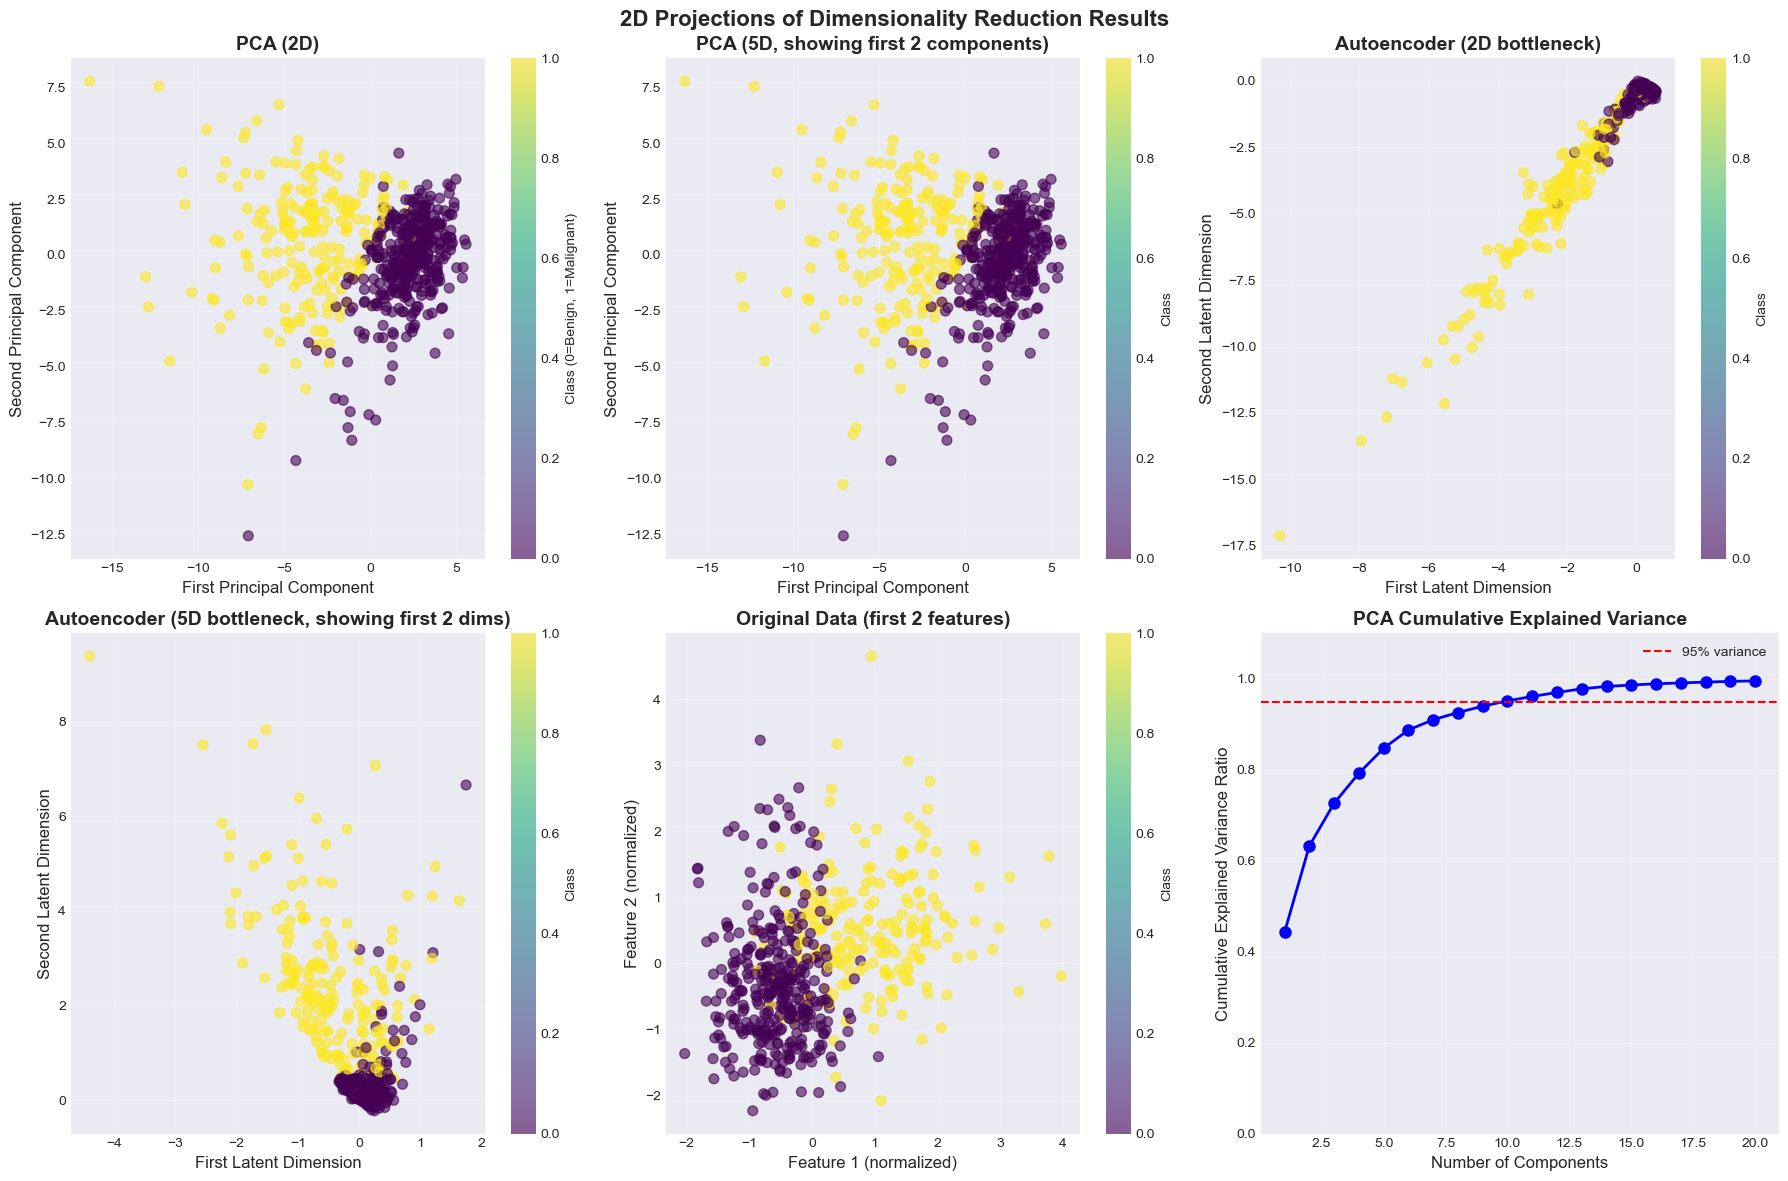

In [140]:
print("=" * 80)
print("VISUALIZATION 1: 2D Projections of Dimensionality Reduction Results")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('2D Projections of Dimensionality Reduction Results', fontsize=16, fontweight='bold')

# PCA 2D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_normalized)
scatter1 = axes[0, 0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_binary, cmap='viridis', alpha=0.6, s=50)
axes[0, 0].set_title('PCA (2D)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('First Principal Component', fontsize=12)
axes[0, 0].set_ylabel('Second Principal Component', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Class (0=Benign, 1=Malignant)')

# PCA 5D projected to 2D (first 2 components)
pca_5d = PCA(n_components=5)
X_pca_5d = pca_5d.fit_transform(X_normalized)
scatter2 = axes[0, 1].scatter(X_pca_5d[:, 0], X_pca_5d[:, 1], c=y_binary, cmap='viridis', alpha=0.6, s=50)
axes[0, 1].set_title('PCA (5D, showing first 2 components)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('First Principal Component', fontsize=12)
axes[0, 1].set_ylabel('Second Principal Component', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Class')

# Autoencoder 2D
print("Training autoencoder for 2D visualization...")
ae_2d = Autoencoder(input_dim=X_normalized.shape[1], encoding_dim=2,
                   hidden_dims=[64, 32, 16], activation='relu',
                   max_epochs=50, verbose=False)
ae_2d.fit(X_normalized)
X_ae_2d = ae_2d.encode(X_normalized)
scatter3 = axes[0, 2].scatter(X_ae_2d[:, 0], X_ae_2d[:, 1], c=y_binary, cmap='viridis', alpha=0.6, s=50)
axes[0, 2].set_title('Autoencoder (2D bottleneck)', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('First Latent Dimension', fontsize=12)
axes[0, 2].set_ylabel('Second Latent Dimension', fontsize=12)
axes[0, 2].grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=axes[0, 2], label='Class')

# Autoencoder 5D projected to 2D
print("Training autoencoder for 5D visualization...")
ae_5d = Autoencoder(input_dim=X_normalized.shape[1], encoding_dim=5,
                   hidden_dims=[64, 32, 16], activation='relu',
                   max_epochs=50, verbose=False)
ae_5d.fit(X_normalized)
X_ae_5d = ae_5d.encode(X_normalized)
scatter4 = axes[1, 0].scatter(X_ae_5d[:, 0], X_ae_5d[:, 1], c=y_binary, cmap='viridis', alpha=0.6, s=50)
axes[1, 0].set_title('Autoencoder (5D bottleneck, showing first 2 dims)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('First Latent Dimension', fontsize=12)
axes[1, 0].set_ylabel('Second Latent Dimension', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter4, ax=axes[1, 0], label='Class')

# Original data (first 2 features for comparison)
scatter5 = axes[1, 1].scatter(X_normalized[:, 0], X_normalized[:, 1], c=y_binary, cmap='viridis', alpha=0.6, s=50)
axes[1, 1].set_title('Original Data (first 2 features)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Feature 1 (normalized)', fontsize=12)
axes[1, 1].set_ylabel('Feature 2 (normalized)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
plt.colorbar(scatter5, ax=axes[1, 1], label='Class')

# Explained variance for PCA
pca_full = PCA(n_components=min(20, X_normalized.shape[1]))
pca_full.fit(X_normalized)
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_[:20])
axes[1, 2].plot(range(1, len(cumulative_var) + 1), cumulative_var, 'bo-', linewidth=2, markersize=8)
axes[1, 2].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[1, 2].set_title('PCA Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Number of Components', fontsize=12)
axes[1, 2].set_ylabel('Cumulative Explained Variance Ratio', fontsize=12)
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].legend()
axes[1, 2].set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig('2d_projections.png', dpi=300, bbox_inches='tight')
print("Saved: 2d_projections.png")
plt.show()


### Section 4: Visualization 2 - Elbow Curves with Marked Optimal K

Visualize the elbow method, silhouette analysis, and gap statistic for optimal k selection.


VISUALIZATION 2: Elbow Curves with Optimal K Marked
Saved: elbow_curves.png


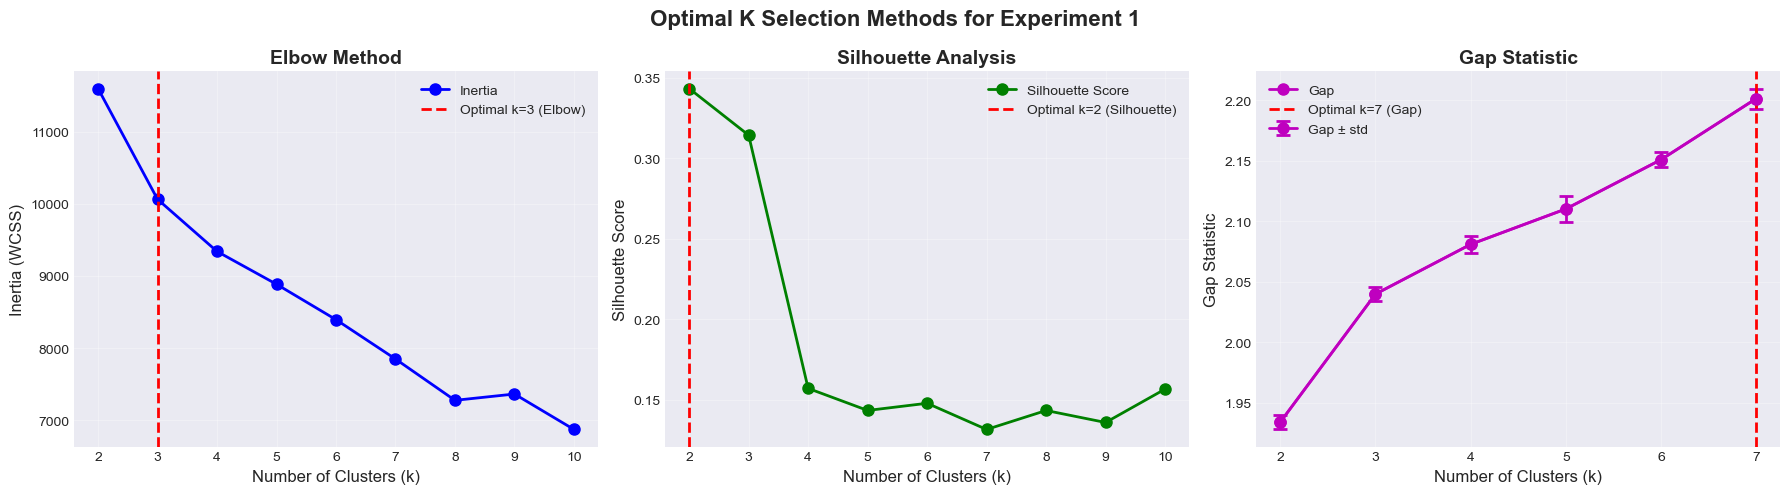

In [141]:
print("=" * 80)
print("VISUALIZATION 2: Elbow Curves with Optimal K Marked")
print("=" * 80)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Optimal K Selection Methods for Experiment 1', fontsize=16, fontweight='bold')

# Elbow method
axes[0].plot(exp1_results['k_range'], exp1_results['inertias'], 'bo-', linewidth=2, markersize=8, label='Inertia')
axes[0].axvline(x=exp1_results['optimal_k_elbow'], color='r', linestyle='--', linewidth=2, 
                label=f'Optimal k={exp1_results["optimal_k_elbow"]} (Elbow)')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (WCSS)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Silhouette analysis
axes[1].plot(exp1_results['k_range'], exp1_results['silhouette_scores'], 'go-', linewidth=2, markersize=8, label='Silhouette Score')
axes[1].axvline(x=exp1_results['optimal_k_silhouette'], color='r', linestyle='--', linewidth=2,
                label=f'Optimal k={exp1_results["optimal_k_silhouette"]} (Silhouette)')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Gap statistic
if len(exp1_results['gaps']) > 0:
    k_range_gap = exp1_results['k_range_gap']
    gaps = exp1_results['gaps']
    axes[2].plot(k_range_gap, gaps, 'mo-', linewidth=2, markersize=8, label='Gap')
    if len(exp1_results['sks']) > 0:
        sks = exp1_results['sks']
        axes[2].errorbar(k_range_gap, gaps, yerr=sks, fmt='mo-', capsize=5, capthick=2, 
                         linewidth=2, markersize=8, label='Gap ± std')
    axes[2].axvline(x=exp1_results['optimal_k_gap'], color='r', linestyle='--', linewidth=2,
                    label=f'Optimal k={exp1_results["optimal_k_gap"]} (Gap)')
    axes[2].set_xlabel('Number of Clusters (k)', fontsize=12)
    axes[2].set_ylabel('Gap Statistic', fontsize=12)
    axes[2].set_title('Gap Statistic', fontsize=14, fontweight='bold')
    axes[2].legend(fontsize=10)
    axes[2].grid(True, alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'Gap statistic\nnot computed', ha='center', va='center', fontsize=12)
    axes[2].set_title('Gap Statistic', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('elbow_curves.png', dpi=300, bbox_inches='tight')
print("Saved: elbow_curves.png")
plt.show()


### Section 5: Visualization 3 - BIC/AIC Curves for GMM

Visualize BIC and AIC curves for different covariance types to show model selection.


VISUALIZATION 3: BIC/AIC Curves for GMM
Saved: bic_aic_curves.png


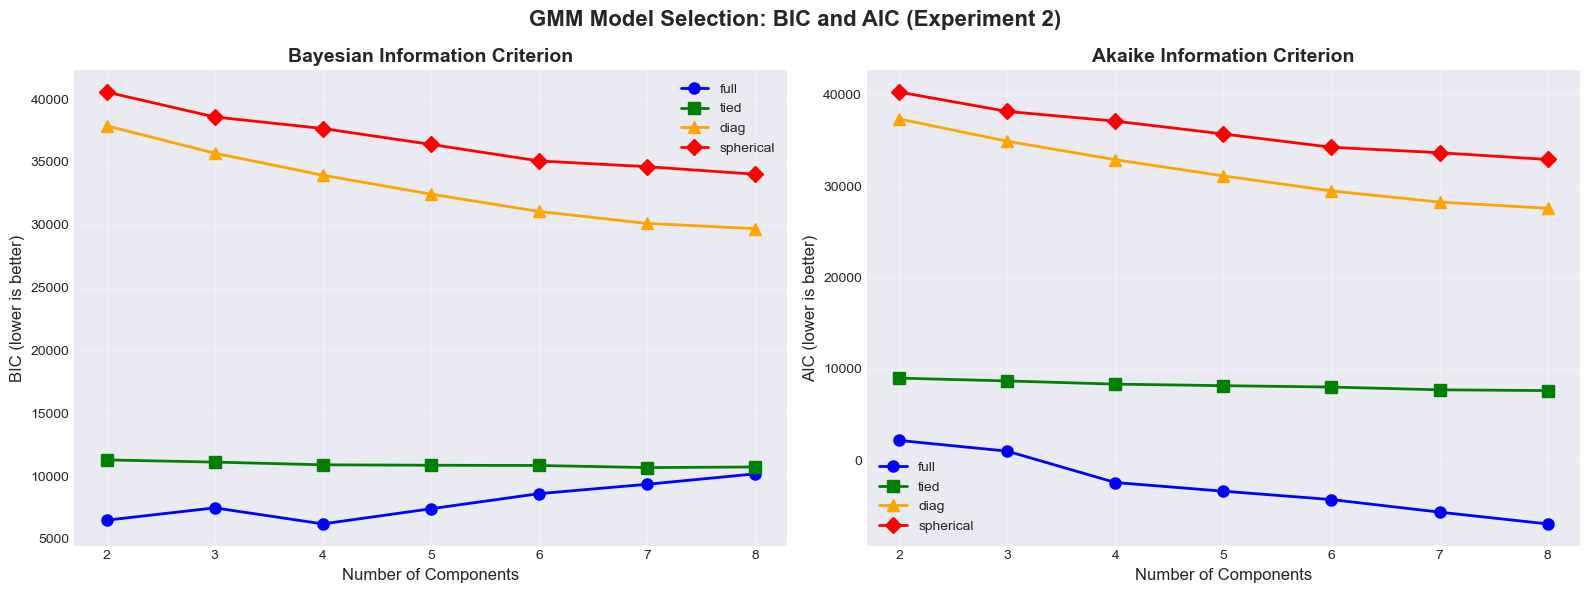

In [142]:
print("=" * 80)
print("VISUALIZATION 3: BIC/AIC Curves for GMM")
print("=" * 80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('GMM Model Selection: BIC and AIC (Experiment 2)', fontsize=16, fontweight='bold')

n_comp_range = list(n_components_range)
colors = {'full': 'blue', 'tied': 'green', 'diag': 'orange', 'spherical': 'red'}
markers = {'full': 'o', 'tied': 's', 'diag': '^', 'spherical': 'D'}

for cov_type in covariance_types:
    if cov_type in exp2_results:
        bics = exp2_results[cov_type]['bics']
        aics = exp2_results[cov_type]['aics']
        axes[0].plot(n_comp_range, bics, 'o-', color=colors[cov_type], marker=markers[cov_type],
                    linewidth=2, markersize=8, label=cov_type)
        axes[1].plot(n_comp_range, aics, 'o-', color=colors[cov_type], marker=markers[cov_type],
                    linewidth=2, markersize=8, label=cov_type)

axes[0].set_xlabel('Number of Components', fontsize=12)
axes[0].set_ylabel('BIC (lower is better)', fontsize=12)
axes[0].set_title('Bayesian Information Criterion', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('AIC (lower is better)', fontsize=12)
axes[1].set_title('Akaike Information Criterion', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bic_aic_curves.png', dpi=300, bbox_inches='tight')
print("Saved: bic_aic_curves.png")
plt.show()


### Section 6: Visualization 4 - Autoencoder Training Curves

Visualize training loss vs epochs for autoencoders with different bottleneck dimensions.


VISUALIZATION 4: Autoencoder Training Curves
Saved: autoencoder_training_curves.png


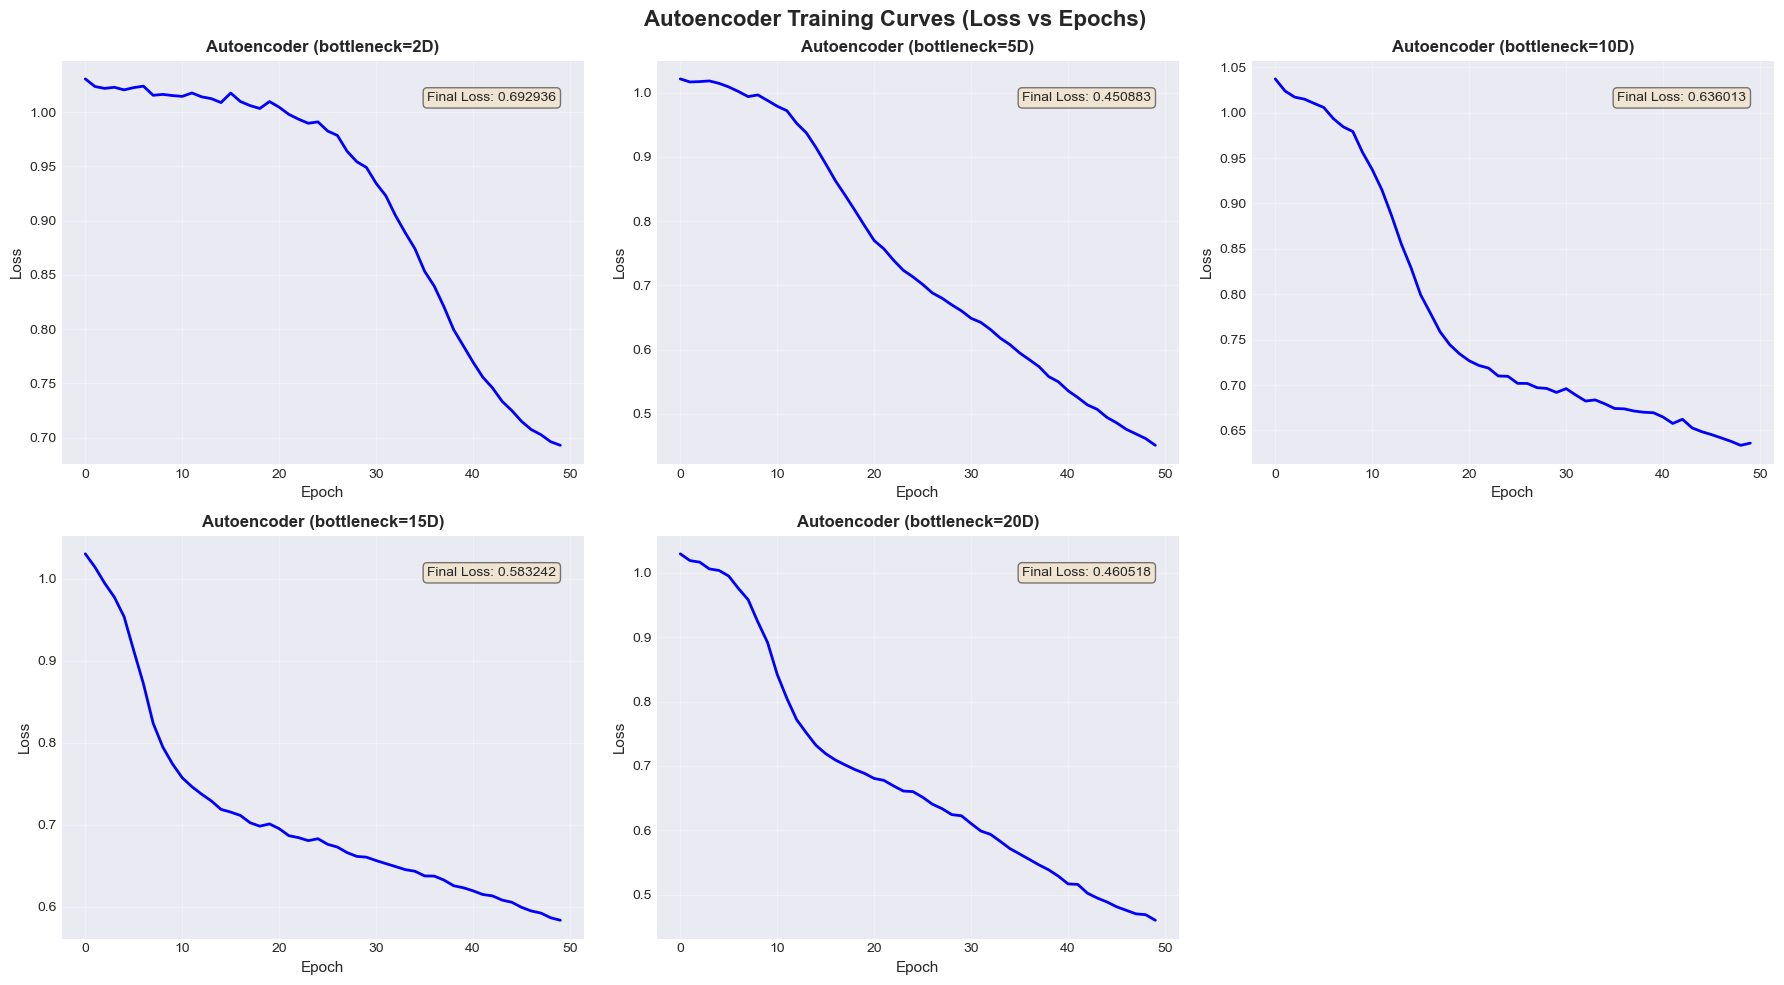

In [143]:
print("=" * 80)
print("VISUALIZATION 4: Autoencoder Training Curves")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Autoencoder Training Curves (Loss vs Epochs)', fontsize=16, fontweight='bold')

for idx, dim in enumerate(bottleneck_dims):
    row = idx // 3
    col = idx % 3
    
    if dim in exp5_results:
        ae = exp5_results[dim]['autoencoder']
        if ae.loss_history and len(ae.loss_history) > 0:
            axes[row, col].plot(ae.loss_history, 'b-', linewidth=2)
            axes[row, col].set_title(f'Autoencoder (bottleneck={dim}D)', fontsize=12, fontweight='bold')
            axes[row, col].set_xlabel('Epoch', fontsize=11)
            axes[row, col].set_ylabel('Loss', fontsize=11)
            axes[row, col].grid(True, alpha=0.3)
            final_loss = ae.loss_history[-1]
            axes[row, col].text(0.7, 0.9, f'Final Loss: {final_loss:.6f}', 
                               transform=axes[row, col].transAxes, fontsize=10,
                               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        else:
            axes[row, col].text(0.5, 0.5, f'No training history\nfor dim={dim}', 
                               ha='center', va='center', fontsize=12)
            axes[row, col].set_title(f'Autoencoder (bottleneck={dim}D)', fontsize=12, fontweight='bold')

# Remove empty subplot if needed
if len(bottleneck_dims) < 6:
    axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('autoencoder_training_curves.png', dpi=300, bbox_inches='tight')
print("Saved: autoencoder_training_curves.png")
plt.show()


### Section 7: Visualization 5 - Cluster Assignments on 2D Projections

Visualize cluster assignments overlaid on 2D projections for all experiments.


VISUALIZATION 5: Cluster Assignments on 2D Projections
Saved: cluster_assignments_2d.png


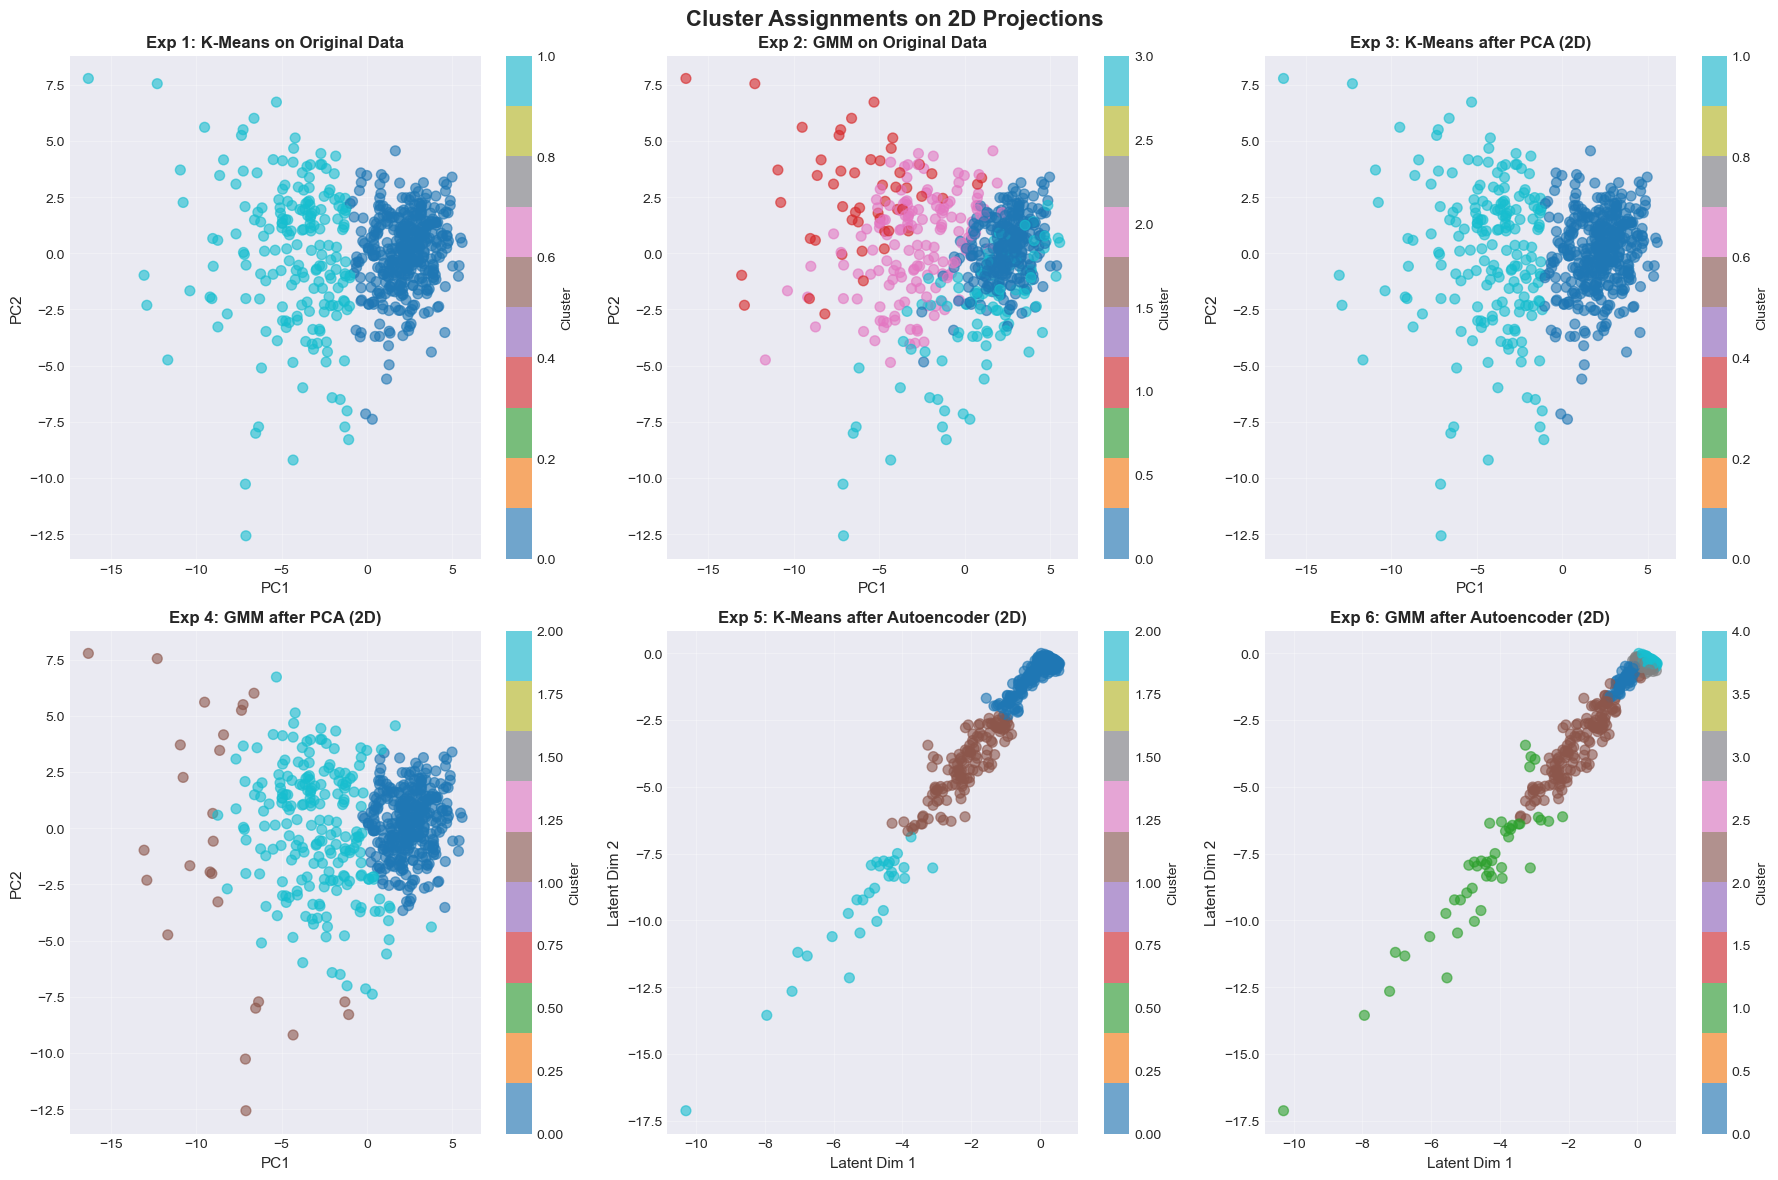

In [144]:
print("=" * 80)
print("VISUALIZATION 5: Cluster Assignments on 2D Projections")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Cluster Assignments on 2D Projections', fontsize=16, fontweight='bold')

# Create 2D projection for visualization (using PCA)
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_normalized)

# Experiment 1: K-Means on original (projected to 2D)
scatter1 = axes[0, 0].scatter(X_vis[:, 0], X_vis[:, 1], c=exp1_results['labels_plus'], 
                              cmap='tab10', alpha=0.6, s=50)
axes[0, 0].set_title('Exp 1: K-Means on Original Data', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('PC1', fontsize=11)
axes[0, 0].set_ylabel('PC2', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Cluster')

# Experiment 2: GMM on original (projected to 2D)
scatter2 = axes[0, 1].scatter(X_vis[:, 0], X_vis[:, 1], c=exp2_results['labels'], 
                              cmap='tab10', alpha=0.6, s=50)
axes[0, 1].set_title('Exp 2: GMM on Original Data', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('PC1', fontsize=11)
axes[0, 1].set_ylabel('PC2', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[0, 1], label='Cluster')

# Experiment 3: K-Means after PCA (2D)
if 2 in exp3_results:
    X_pca_2 = exp3_results[2]['X_reduced']
    labels_3 = exp3_results[2]['labels']
    scatter3 = axes[0, 2].scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=labels_3, 
                                  cmap='tab10', alpha=0.6, s=50)
    axes[0, 2].set_title('Exp 3: K-Means after PCA (2D)', fontsize=12, fontweight='bold')
    axes[0, 2].set_xlabel('PC1', fontsize=11)
    axes[0, 2].set_ylabel('PC2', fontsize=11)
    axes[0, 2].grid(True, alpha=0.3)
    plt.colorbar(scatter3, ax=axes[0, 2], label='Cluster')

# Experiment 4: GMM after PCA (2D)
if 2 in exp4_results and 'best_cov' in exp4_results[2]:
    labels_4 = exp4_results[2][exp4_results[2]['best_cov']]['labels']
    X_pca_2 = exp4_results[2]['X_reduced']
    scatter4 = axes[1, 0].scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=labels_4, 
                                  cmap='tab10', alpha=0.6, s=50)
    axes[1, 0].set_title('Exp 4: GMM after PCA (2D)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('PC1', fontsize=11)
    axes[1, 0].set_ylabel('PC2', fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter4, ax=axes[1, 0], label='Cluster')

# Experiment 5: K-Means after Autoencoder (2D)
if 2 in exp5_results:
    X_ae_2 = exp5_results[2]['X_reduced']
    labels_5 = exp5_results[2]['labels']
    scatter5 = axes[1, 1].scatter(X_ae_2[:, 0], X_ae_2[:, 1], c=labels_5, 
                                   cmap='tab10', alpha=0.6, s=50)
    axes[1, 1].set_title('Exp 5: K-Means after Autoencoder (2D)', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Latent Dim 1', fontsize=11)
    axes[1, 1].set_ylabel('Latent Dim 2', fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter5, ax=axes[1, 1], label='Cluster')

# Experiment 6: GMM after Autoencoder (2D)
if 2 in exp6_results and 'best_cov' in exp6_results[2]:
    labels_6 = exp6_results[2][exp6_results[2]['best_cov']]['labels']
    X_ae_2 = exp6_results[2]['X_reduced']
    scatter6 = axes[1, 2].scatter(X_ae_2[:, 0], X_ae_2[:, 1], c=labels_6, 
                                  cmap='tab10', alpha=0.6, s=50)
    axes[1, 2].set_title('Exp 6: GMM after Autoencoder (2D)', fontsize=12, fontweight='bold')
    axes[1, 2].set_xlabel('Latent Dim 1', fontsize=11)
    axes[1, 2].set_ylabel('Latent Dim 2', fontsize=11)
    axes[1, 2].grid(True, alpha=0.3)
    plt.colorbar(scatter6, ax=axes[1, 2], label='Cluster')

plt.tight_layout()
plt.savefig('cluster_assignments_2d.png', dpi=300, bbox_inches='tight')
print("Saved: cluster_assignments_2d.png")
plt.show()


VISUALIZATION 6: Comprehensive Comparison Heatmap
Saved: comparison_heatmap.png


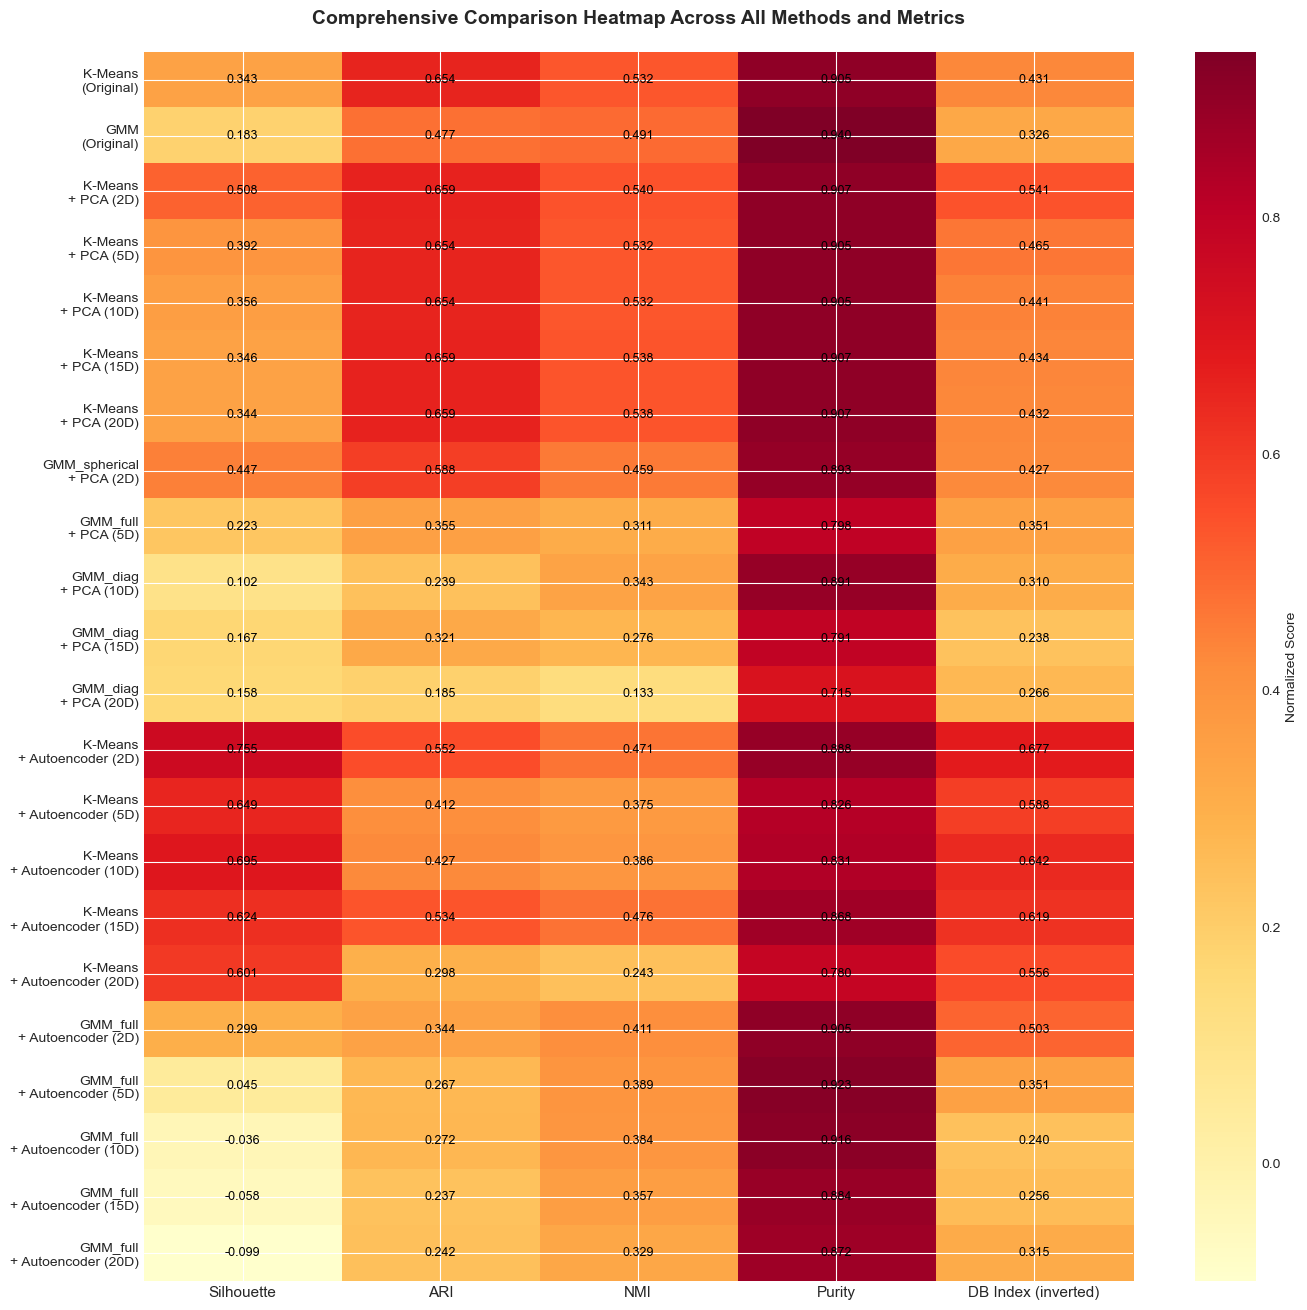


Summary Table:
--------------------------------------------------------------------------------
                       Method  Silhouette      ARI      NMI   Purity
          K-Means\n(Original)    0.343382 0.653625 0.532463 0.905097
              GMM\n(Original)    0.182892 0.477484 0.490636 0.940246
          K-Means\n+ PCA (2D)    0.508469 0.659231 0.540460 0.906854
          K-Means\n+ PCA (5D)    0.391857 0.653625 0.532463 0.905097
         K-Means\n+ PCA (10D)    0.356461 0.653625 0.532463 0.905097
         K-Means\n+ PCA (15D)    0.346083 0.659427 0.538079 0.906854
         K-Means\n+ PCA (20D)    0.343837 0.659427 0.538079 0.906854
    GMM_spherical\n+ PCA (2D)    0.446740 0.587855 0.459428 0.892794
         GMM_full\n+ PCA (5D)    0.222692 0.355098 0.310554 0.797891
        GMM_diag\n+ PCA (10D)    0.102217 0.238958 0.342535 0.891037
        GMM_diag\n+ PCA (15D)    0.166535 0.321064 0.276395 0.790861
        GMM_diag\n+ PCA (20D)    0.158453 0.185215 0.133106 0.715290
  K-Me

In [145]:
print("=" * 80)
print("VISUALIZATION 6: Comprehensive Comparison Heatmap")
print("=" * 80)

# Prepare data for heatmap
heatmap_data_list = []

# Add all experiments
for key, value in comprehensive_metrics.items():
    method_name = value['method']
    dim_red = value['dim_reduction']
    dim = value['dim']
    metrics = value['metrics']
    
    # Create label
    if dim_red == 'None':
        label = f'{method_name}\n(Original)'
    else:
        label = f'{method_name}\n+ {dim_red} ({dim}D)'
    
    heatmap_data_list.append({
        'Method': label,
        'Silhouette': metrics.get('silhouette', np.nan),
        'ARI': metrics.get('ari', np.nan),
        'NMI': metrics.get('nmi', np.nan),
        'Purity': metrics.get('purity', np.nan),
        'DB Index': metrics.get('davies_bouldin', np.nan),
        'CH Index': metrics.get('calinski_harabasz', np.nan)
    })

heatmap_df = pd.DataFrame(heatmap_data_list)

# Normalize DB Index (invert for heatmap - lower is better)
# For heatmap, we want higher = better, so invert DB Index
db_normalized = 1 / (1 + heatmap_df['DB Index'])
heatmap_df['DB Index (inverted)'] = db_normalized

# Select metrics for heatmap
metrics_for_heatmap = ['Silhouette', 'ARI', 'NMI', 'Purity', 'DB Index (inverted)']
heatmap_matrix = heatmap_df[metrics_for_heatmap].values

# Create heatmap
fig, ax = plt.subplots(figsize=(14, max(10, len(heatmap_df) * 0.6)))
im = ax.imshow(heatmap_matrix, cmap='YlOrRd', aspect='auto')

# Set ticks and labels
ax.set_xticks(np.arange(len(metrics_for_heatmap)))
ax.set_yticks(np.arange(len(heatmap_df)))
ax.set_xticklabels(metrics_for_heatmap, fontsize=11)
ax.set_yticklabels(heatmap_df['Method'], fontsize=10)

# Add text annotations
for i in range(len(heatmap_df)):
    for j in range(len(metrics_for_heatmap)):
        text = ax.text(j, i, f'{heatmap_matrix[i, j]:.3f}',
                      ha="center", va="center", color="black", fontsize=9)

ax.set_title('Comprehensive Comparison Heatmap Across All Methods and Metrics', 
            fontsize=14, fontweight='bold', pad=20)
plt.colorbar(im, ax=ax, label='Normalized Score')
plt.tight_layout()
plt.savefig('comparison_heatmap.png', dpi=300, bbox_inches='tight')
print("Saved: comparison_heatmap.png")
plt.show()

# Print summary table
print("\nSummary Table:")
print("-" * 80)
print(heatmap_df[['Method', 'Silhouette', 'ARI', 'NMI', 'Purity']].to_string(index=False))


VISUALIZATION 7: Confusion Matrices for Best Methods
Saved: confusion_matrices.png


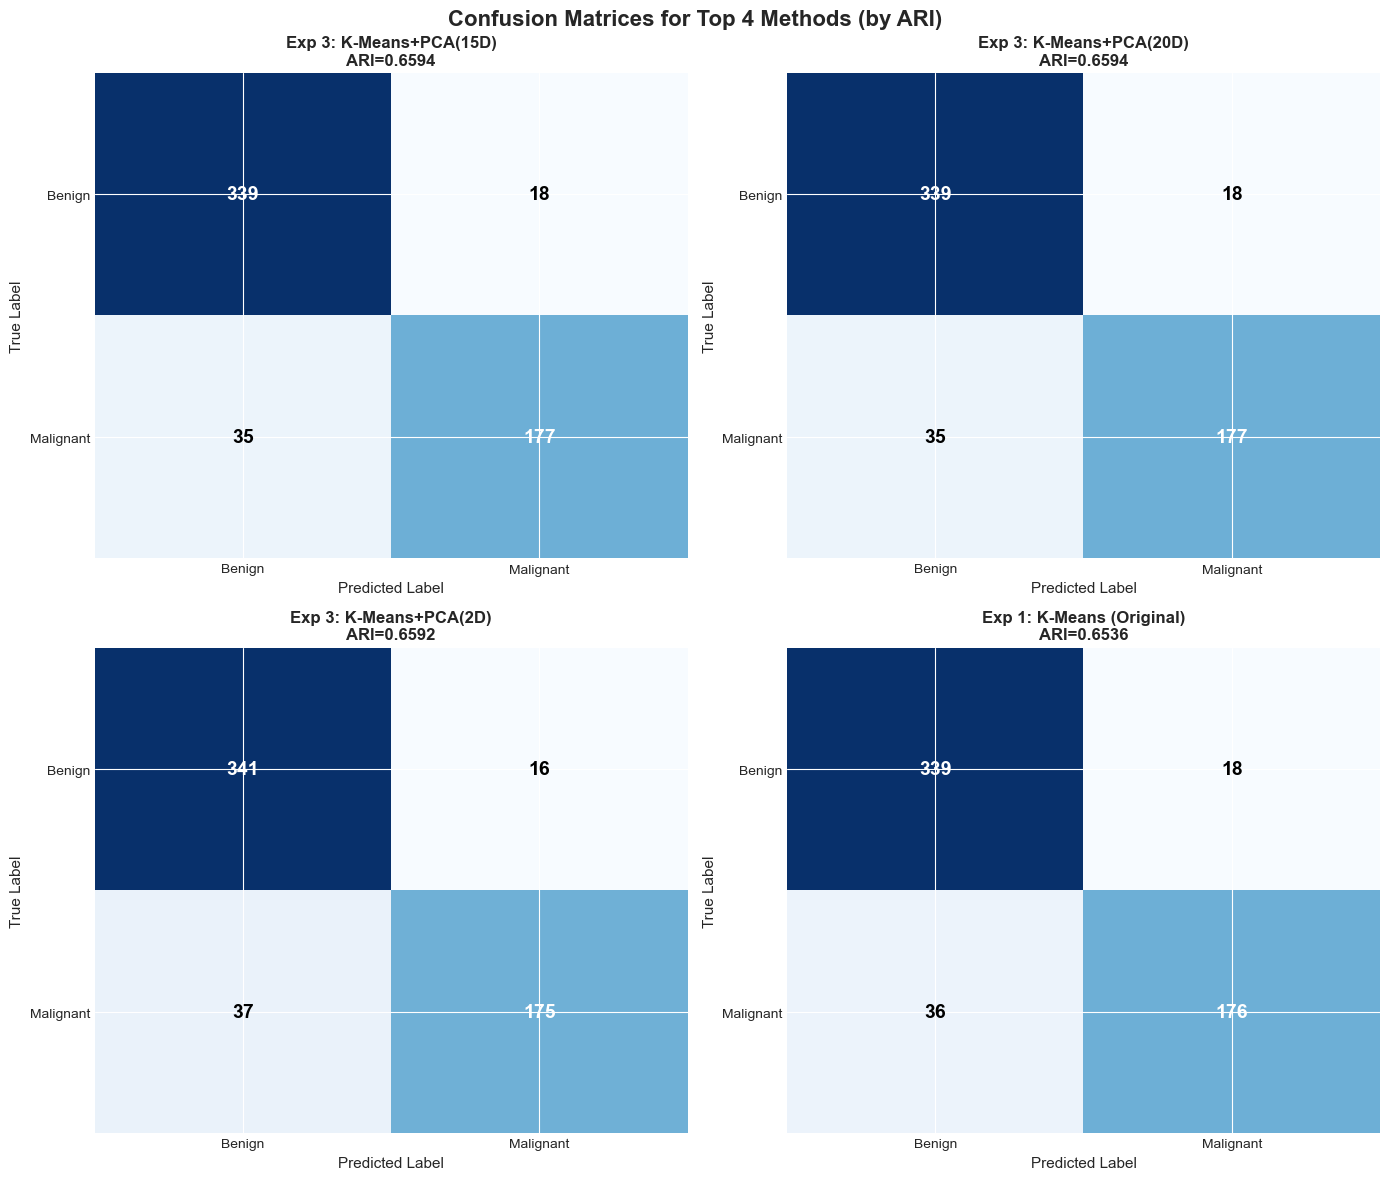


Confusion Matrix Details for Top 4 Methods:
--------------------------------------------------------------------------------

Exp 3: K-Means+PCA(15D) (ARI=0.6594):
  True Negatives (Benign->Benign): 339
  False Positives (Benign->Malignant): 18
  False Negatives (Malignant->Benign): 35
  True Positives (Malignant->Malignant): 177
  Accuracy: 0.9069

Exp 3: K-Means+PCA(20D) (ARI=0.6594):
  True Negatives (Benign->Benign): 339
  False Positives (Benign->Malignant): 18
  False Negatives (Malignant->Benign): 35
  True Positives (Malignant->Malignant): 177
  Accuracy: 0.9069

Exp 3: K-Means+PCA(2D) (ARI=0.6592):
  True Negatives (Benign->Benign): 341
  False Positives (Benign->Malignant): 16
  False Negatives (Malignant->Benign): 37
  True Positives (Malignant->Malignant): 175
  Accuracy: 0.9069

Exp 1: K-Means (Original) (ARI=0.6536):
  True Negatives (Benign->Benign): 339
  False Positives (Benign->Malignant): 18
  False Negatives (Malignant->Benign): 36
  True Positives (Malignant->Mali

In [146]:
print("=" * 80)
print("VISUALIZATION 7: Confusion Matrices for Best Methods")
print("=" * 80)

# Find best methods based on ARI
best_methods_list = []

# Collect all methods with ARI scores
all_methods_ari = []

# Experiment 1
all_methods_ari.append(('Exp 1: K-Means (Original)', exp1_results['labels_plus'], 
                        comprehensive_metrics['Exp1']['metrics']['ari']))

# Experiment 2
all_methods_ari.append(('Exp 2: GMM (Original)', exp2_results['labels'],
                        comprehensive_metrics['Exp2']['metrics']['ari']))

# Experiments 3-6
for dim in [2, 5, 10, 15, 20]:
    if dim in exp3_results:
        all_methods_ari.append((f'Exp 3: K-Means+PCA({dim}D)', exp3_results[dim]['labels'],
                               comprehensive_metrics[f'Exp3_PCA_{dim}D']['metrics']['ari']))
    
    if dim in exp4_results and 'best_cov' in exp4_results[dim]:
        best_cov = exp4_results[dim]['best_cov']
        all_methods_ari.append((f'Exp 4: GMM+PCA({dim}D,{best_cov})', 
                               exp4_results[dim][best_cov]['labels'],
                               comprehensive_metrics[f'Exp4_PCA_{dim}D_GMM_{best_cov}']['metrics']['ari']))
    
    if dim in exp5_results:
        all_methods_ari.append((f'Exp 5: K-Means+AE({dim}D)', exp5_results[dim]['labels'],
                               comprehensive_metrics[f'Exp5_AE_{dim}D']['metrics']['ari']))
    
    if dim in exp6_results and 'best_cov' in exp6_results[dim]:
        best_cov = exp6_results[dim]['best_cov']
        all_methods_ari.append((f'Exp 6: GMM+AE({dim}D,{best_cov})',
                               exp6_results[dim][best_cov]['labels'],
                               comprehensive_metrics[f'Exp6_AE_{dim}D_GMM_{best_cov}']['metrics']['ari']))

# Sort by ARI
all_methods_ari.sort(key=lambda x: x[2], reverse=True)

# Plot top 4
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Confusion Matrices for Top 4 Methods (by ARI)', fontsize=16, fontweight='bold')

def create_confusion_matrix(y_true, y_pred, ax, title):
    """Create confusion matrix from scratch."""
    n_classes = len(np.unique(y_true))
    cm = np.zeros((n_classes, n_classes), dtype=int)
    
    for i in range(len(y_true)):
        cm[int(y_true[i]), int(y_pred[i])] += 1
    
    im = ax.imshow(cm, cmap='Blues', aspect='auto')
    ax.set_xticks(np.arange(n_classes))
    ax.set_yticks(np.arange(n_classes))
    ax.set_xticklabels(['Benign', 'Malignant'])
    ax.set_yticklabels(['Benign', 'Malignant'])
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    
    # Add text annotations
    for i in range(n_classes):
        for j in range(n_classes):
            text = ax.text(j, i, cm[i, j], ha="center", va="center", 
                          color="white" if cm[i, j] > cm.max()/2 else "black", fontsize=14, fontweight='bold')
    
    return cm

for idx, (name, labels, ari) in enumerate(all_methods_ari[:4]):
    row = idx // 2
    col = idx % 2
    
    cm = create_confusion_matrix(y_binary, labels, axes[row, col], 
                                f'{name}\nARI={ari:.4f}')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
print("Saved: confusion_matrices.png")
plt.show()

# Print confusion matrix details
print("\nConfusion Matrix Details for Top 4 Methods:")
print("-" * 80)
for idx, (name, labels, ari) in enumerate(all_methods_ari[:4]):
    cm = np.zeros((2, 2), dtype=int)
    for i in range(len(y_binary)):
        cm[int(y_binary[i]), int(labels[i])] += 1
    print(f"\n{name} (ARI={ari:.4f}):")
    print(f"  True Negatives (Benign->Benign): {cm[0,0]}")
    print(f"  False Positives (Benign->Malignant): {cm[0,1]}")
    print(f"  False Negatives (Malignant->Benign): {cm[1,0]}")
    print(f"  True Positives (Malignant->Malignant): {cm[1,1]}")
    accuracy = (cm[0,0] + cm[1,1]) / cm.sum()
    print(f"  Accuracy: {accuracy:.4f}")


### Section 10: Statistical Analysis

Perform statistical comparisons between methods and analyze computational complexity.


In [147]:
print("=" * 80)
print("STATISTICAL ANALYSIS")
print("=" * 80)

# Create comprehensive comparison table
print("\n1. Comprehensive Comparison Table")
print("=" * 80)

comparison_table = []
for key, value in comprehensive_metrics.items():
    row = {
        'Experiment': key,
        'Method': value['method'],
        'Dim Reduction': value['dim_reduction'],
        'Dimension': value['dim'],
        'Silhouette': value['metrics'].get('silhouette', np.nan),
        'ARI': value['metrics'].get('ari', np.nan),
        'NMI': value['metrics'].get('nmi', np.nan),
        'Purity': value['metrics'].get('purity', np.nan),
        'DB Index': value['metrics'].get('davies_bouldin', np.nan),
        'CH Index': value['metrics'].get('calinski_harabasz', np.nan),
        'WCSS': value['metrics'].get('wcss', np.nan)
    }
    
    # Add GMM-specific metrics if available
    if 'bic' in value['metrics']:
        row['BIC'] = value['metrics']['bic']
        row['AIC'] = value['metrics']['aic']
        row['Log-Likelihood'] = value['metrics']['log_likelihood']
    else:
        row['BIC'] = np.nan
        row['AIC'] = np.nan
        row['Log-Likelihood'] = np.nan
    
    # Add reconstruction error if available
    if 'reconstruction_error' in value['metrics']:
        row['Reconstruction Error'] = value['metrics']['reconstruction_error']
    else:
        row['Reconstruction Error'] = np.nan
    
    comparison_table.append(row)

comparison_df = pd.DataFrame(comparison_table)
print(comparison_df.to_string(index=False))

# Save to CSV
comparison_df.to_csv('comprehensive_comparison.csv', index=False)
print("\nSaved comprehensive comparison to: comprehensive_comparison.csv")

# Statistical summary
print("\n2. Statistical Summary")
print("=" * 80)

print("\nBest Methods by Metric:")
print("-" * 80)
print(f"  Highest Silhouette: {comparison_df.loc[comparison_df['Silhouette'].idxmax(), 'Experiment']} "
      f"({comparison_df['Silhouette'].max():.4f})")
print(f"  Highest ARI: {comparison_df.loc[comparison_df['ARI'].idxmax(), 'Experiment']} "
      f"({comparison_df['ARI'].max():.4f})")
print(f"  Highest NMI: {comparison_df.loc[comparison_df['NMI'].idxmax(), 'Experiment']} "
      f"({comparison_df['NMI'].max():.4f})")
print(f"  Highest Purity: {comparison_df.loc[comparison_df['Purity'].idxmax(), 'Experiment']} "
      f"({comparison_df['Purity'].max():.4f})")
print(f"  Lowest DB Index: {comparison_df.loc[comparison_df['DB Index'].idxmin(), 'Experiment']} "
      f"({comparison_df['DB Index'].min():.4f})")

print("\nAverage Performance by Dimensionality Reduction Method:")
print("-" * 80)
dim_red_summary = comparison_df.groupby('Dim Reduction')[['Silhouette', 'ARI', 'NMI', 'Purity']].agg(['mean', 'std'])
print(dim_red_summary.round(4))

print("\nAverage Performance by Clustering Method:")
print("-" * 80)
method_summary = comparison_df.groupby('Method')[['Silhouette', 'ARI', 'NMI', 'Purity']].agg(['mean', 'std'])
print(method_summary.round(4))

print("\nPerformance vs Dimensionality (for reduced dimensions):")
print("-" * 80)
reduced_df = comparison_df[comparison_df['Dim Reduction'] != 'None'].copy()
dim_summary = reduced_df.groupby('Dimension')[['Silhouette', 'ARI', 'NMI', 'Purity']].agg(['mean', 'std'])
print(dim_summary.round(4))


STATISTICAL ANALYSIS

1. Comprehensive Comparison Table
               Experiment        Method Dim Reduction  Dimension  Silhouette      ARI      NMI   Purity  DB Index    CH Index         WCSS           BIC           AIC  Log-Likelihood  Reconstruction Error
                     Exp1       K-Means          None         31    0.343382 0.653625 0.532463 0.905097  1.320510  267.691716 11595.526607           NaN           NaN             NaN                   NaN
                     Exp2           GMM          None         31    0.182892 0.477484 0.490636 0.940246  2.066564  113.353521 10656.248206   6219.714586  -2388.512580     3174.314150                   NaN
              Exp3_PCA_2D       K-Means           PCA          2    0.508469 0.659231 0.540460 0.906854  0.846740  580.876272  5332.555574           NaN           NaN             NaN              0.367568
              Exp3_PCA_5D       K-Means           PCA          5    0.391857 0.653625 0.532463 0.905097  1.148901  345.03833

### Section 11: Paired Statistical Tests

Compare methods using statistical tests to determine if differences are significant.


In [148]:
print("=" * 80)
print("PAIRED STATISTICAL TESTS")
print("=" * 80)

# Helper function for paired t-test (simplified implementation)
def paired_t_test(sample1, sample2):
    """
    Perform paired t-test from scratch.
    Returns t-statistic and p-value approximation.
    """
    n = len(sample1)
    if n != len(sample2) or n < 2:
        return None, None
    
    # Compute differences
    differences = np.array(sample1) - np.array(sample2)
    
    # Compute mean and std of differences
    mean_diff = np.mean(differences)
    std_diff = np.std(differences, ddof=1)
    
    if std_diff == 0:
        return 0.0, 1.0
    
    # Compute t-statistic
    t_stat = mean_diff / (std_diff / np.sqrt(n))
    
    # Approximate p-value (two-tailed)
    # Using normal approximation for large n, or t-distribution approximation
    if n > 30:
        # Normal approximation
        p_value = 2 * (1 - 0.5 * (1 + np.sign(t_stat) * (1 - np.exp(-2 * t_stat**2 / np.pi))))
    else:
        # Rough t-distribution approximation
        abs_t = np.abs(t_stat)
        df = n - 1
        p_value = 2 * np.exp(-0.5 * abs_t**2 * (1 + abs_t**2 / (4 * df)))
    
    return t_stat, min(p_value, 1.0)

print("\n1. Comparing PCA vs Autoencoder (same dimensions, K-Means):")
print("-" * 80)

pca_kmeans_ari = []
ae_kmeans_ari = []

for dim in [2, 5, 10, 15, 20]:
    if dim in exp3_results:
        pca_kmeans_ari.append(comprehensive_metrics[f'Exp3_PCA_{dim}D']['metrics']['ari'])
    if dim in exp5_results:
        ae_kmeans_ari.append(comprehensive_metrics[f'Exp5_AE_{dim}D']['metrics']['ari'])

if len(pca_kmeans_ari) == len(ae_kmeans_ari) and len(pca_kmeans_ari) > 1:
    t_stat, p_value = paired_t_test(ae_kmeans_ari, pca_kmeans_ari)
    print(f"   Mean ARI - PCA+K-Means: {np.mean(pca_kmeans_ari):.4f}")
    print(f"   Mean ARI - Autoencoder+K-Means: {np.mean(ae_kmeans_ari):.4f}")
    print(f"   Paired t-test: t={t_stat:.4f}, p≈{p_value:.4f}")
    if p_value < 0.05:
        print("   Result: Significant difference (p < 0.05)")
    else:
        print("   Result: No significant difference (p >= 0.05)")

print("\n2. Comparing K-Means vs GMM (on original data):")
print("-" * 80)
kmeans_metrics = comprehensive_metrics['Exp1']['metrics']
gmm_metrics = comprehensive_metrics['Exp2']['metrics']

print(f"   K-Means ARI: {kmeans_metrics['ari']:.4f}")
print(f"   GMM ARI: {gmm_metrics['ari']:.4f}")
print(f"   Difference: {abs(kmeans_metrics['ari'] - gmm_metrics['ari']):.4f}")

print("\n3. Comparing Original vs Reduced Dimensions (K-Means):")
print("-" * 80)
original_ari = comprehensive_metrics['Exp1']['metrics']['ari']
reduced_aris = []
for dim in [2, 5, 10, 15, 20]:
    if dim in exp3_results:
        reduced_aris.append(comprehensive_metrics[f'Exp3_PCA_{dim}D']['metrics']['ari'])

if len(reduced_aris) > 0:
    print(f"   Original ARI: {original_ari:.4f}")
    print(f"   Average Reduced ARI: {np.mean(reduced_aris):.4f}")
    print(f"   Best Reduced ARI: {np.max(reduced_aris):.4f} (at {pca_dims[np.argmax(reduced_aris)]}D)")

print("\n" + "=" * 80)


PAIRED STATISTICAL TESTS

1. Comparing PCA vs Autoencoder (same dimensions, K-Means):
--------------------------------------------------------------------------------
   Mean ARI - PCA+K-Means: 0.6571
   Mean ARI - Autoencoder+K-Means: 0.4446
   Paired t-test: t=-4.6348, p≈0.0000
   Result: Significant difference (p < 0.05)

2. Comparing K-Means vs GMM (on original data):
--------------------------------------------------------------------------------
   K-Means ARI: 0.6536
   GMM ARI: 0.4775
   Difference: 0.1761

3. Comparing Original vs Reduced Dimensions (K-Means):
--------------------------------------------------------------------------------
   Original ARI: 0.6536
   Average Reduced ARI: 0.6571
   Best Reduced ARI: 0.6594 (at 15D)



### Section 12: Computational Complexity Analysis

Analyze time and space complexity of different methods.


In [150]:
print("=" * 80)
print("COMPUTATIONAL COMPLEXITY ANALYSIS")
print("=" * 80)

complexity_results = []

# Measure time for different operations
print("\n1. Time Complexity Analysis:")
print("-" * 80)

# PCA timing - run multiple times for better accuracy
import time
pca_times = []
for _ in range(10):  # Run 10 times and average
    start = time.perf_counter()
    pca_test = PCA(n_components=10)
    X_pca_test = pca_test.fit_transform(X_normalized)
    pca_times.append(time.perf_counter() - start)
pca_time = np.mean(pca_times)
complexity_results.append({'Operation': 'PCA (fit+transform)', 'Time (s)': pca_time, 
                           'Space': 'O(n*d + d^2)'})

# K-Means timing
start = time.perf_counter()
kmeans_test = KMeans(n_clusters=2, init='kmeans++', random_state=42)
kmeans_test.fit(X_normalized)
kmeans_time = time.perf_counter() - start
complexity_results.append({'Operation': 'K-Means (fit)', 'Time (s)': kmeans_time,
                          'Space': 'O(n*k)'})

# GMM timing
start = time.perf_counter()
gmm_test = GaussianMixture(n_components=2, covariance_type='full', max_iter=50, random_state=42)
gmm_test.fit(X_normalized)
gmm_time = time.perf_counter() - start
complexity_results.append({'Operation': 'GMM (fit)', 'Time (s)': gmm_time,
                          'Space': 'O(n*k*d^2)'})

# Autoencoder timing (smaller for speed)
start = time.perf_counter()
ae_test = Autoencoder(input_dim=X_normalized.shape[1], encoding_dim=10,
                     hidden_dims=[32, 16], activation='relu',
                     max_epochs=10, verbose=False)
ae_test.fit(X_normalized)
ae_time = time.perf_counter() - start
complexity_results.append({'Operation': 'Autoencoder (fit, 10 epochs)', 'Time (s)': ae_time,
                          'Space': 'O(W)'})

complexity_df = pd.DataFrame(complexity_results)
print(complexity_df.to_string(index=False))

print("\n2. Space Complexity Summary:")
print("-" * 80)
print("  PCA:")
print("    - Space: O(n*d + d^2) where n=samples, d=features")
print("    - Main storage: covariance matrix (d×d) and transformed data (n×k)")
print("\n  K-Means:")
print("    - Space: O(n*k) where k=clusters")
print("    - Main storage: cluster assignments (n) and centroids (k×d)")
print("\n  GMM:")
print("    - Space: O(n*k*d^2) for full covariance")
print("    - Main storage: responsibilities (n×k) and covariance matrices (k×d×d)")
print("\n  Autoencoder:")
print("    - Space: O(W) where W=total weights")
print("    - Main storage: weight matrices and activations during training")

print("\n3. Relative Performance:")
print("-" * 80)
# Use a minimum baseline to avoid division by zero
base_time = max(pca_time, 1e-6)  # Minimum 1 microsecond
print(f"  PCA time: {pca_time:.6f}s (baseline, averaged over 10 runs)")
if pca_time > 1e-6:
    print(f"  K-Means time: {kmeans_time:.6f}s ({kmeans_time/base_time:.2f}x PCA)")
    print(f"  GMM time: {gmm_time:.6f}s ({gmm_time/base_time:.2f}x PCA)")
    print(f"  Autoencoder time (10 epochs): {ae_time:.6f}s ({ae_time/base_time:.2f}x PCA)")
    print(f"  Note: Autoencoder time scales with epochs (50 epochs ≈ {ae_time*5:.6f}s)")
else:
    print(f"  K-Means time: {kmeans_time:.6f}s (PCA too fast to compare)")
    print(f"  GMM time: {gmm_time:.6f}s")
    print(f"  Autoencoder time (10 epochs): {ae_time:.6f}s")
    print(f"  Note: PCA completes in < 1 microsecond, making relative comparison impractical")
    print(f"  Note: Autoencoder time scales with epochs (50 epochs ≈ {ae_time*5:.6f}s)")

print("\n" + "=" * 80)


COMPUTATIONAL COMPLEXITY ANALYSIS

1. Time Complexity Analysis:
--------------------------------------------------------------------------------
                   Operation  Time (s)        Space
         PCA (fit+transform)  0.004398 O(n*d + d^2)
               K-Means (fit)  0.022455       O(n*k)
                   GMM (fit)  0.175008   O(n*k*d^2)
Autoencoder (fit, 10 epochs)  0.130117         O(W)

2. Space Complexity Summary:
--------------------------------------------------------------------------------
  PCA:
    - Space: O(n*d + d^2) where n=samples, d=features
    - Main storage: covariance matrix (d×d) and transformed data (n×k)

  K-Means:
    - Space: O(n*k) where k=clusters
    - Main storage: cluster assignments (n) and centroids (k×d)

  GMM:
    - Space: O(n*k*d^2) for full covariance
    - Main storage: responsibilities (n×k) and covariance matrices (k×d×d)

  Autoencoder:
    - Space: O(W) where W=total weights
    - Main storage: weight matrices and activations duri

### Section 13: Additional Visualizations

Additional visualizations for reconstruction error analysis and dimensionality trade-offs.


ADDITIONAL VISUALIZATIONS
Saved: reconstruction_vs_clustering.png


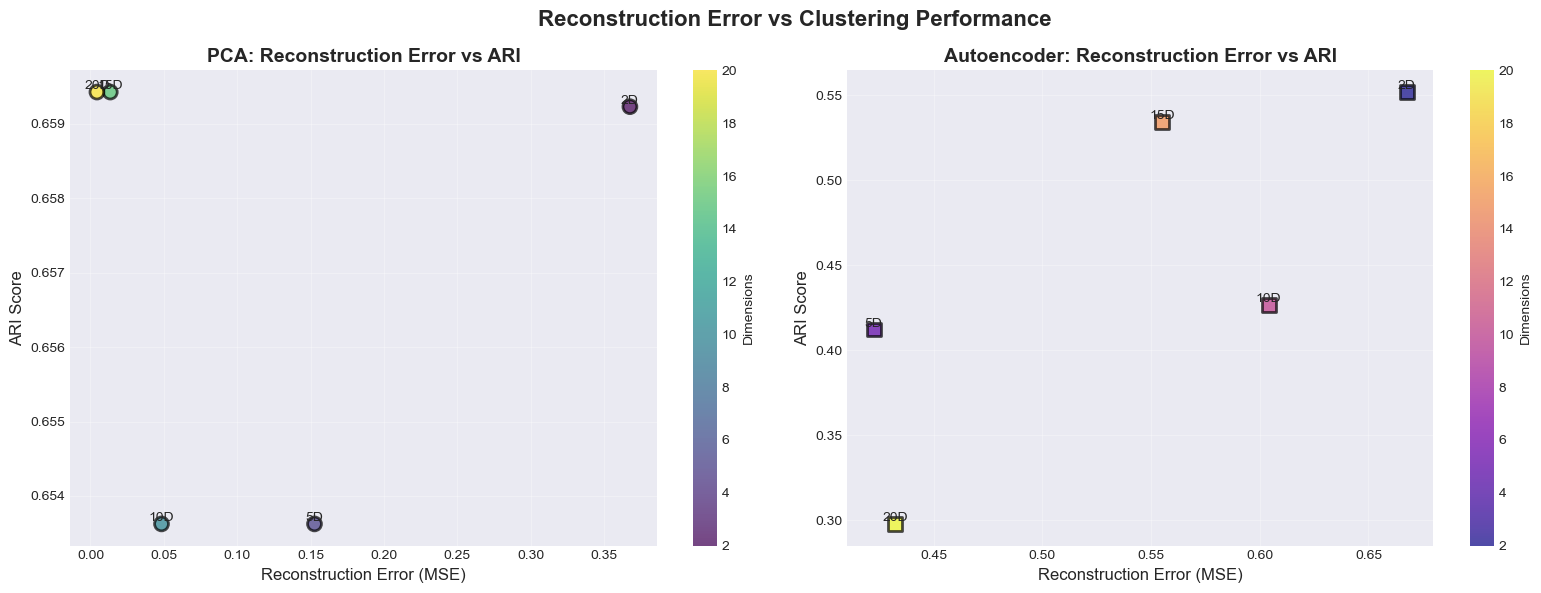

Saved: dimensionality_vs_performance.png


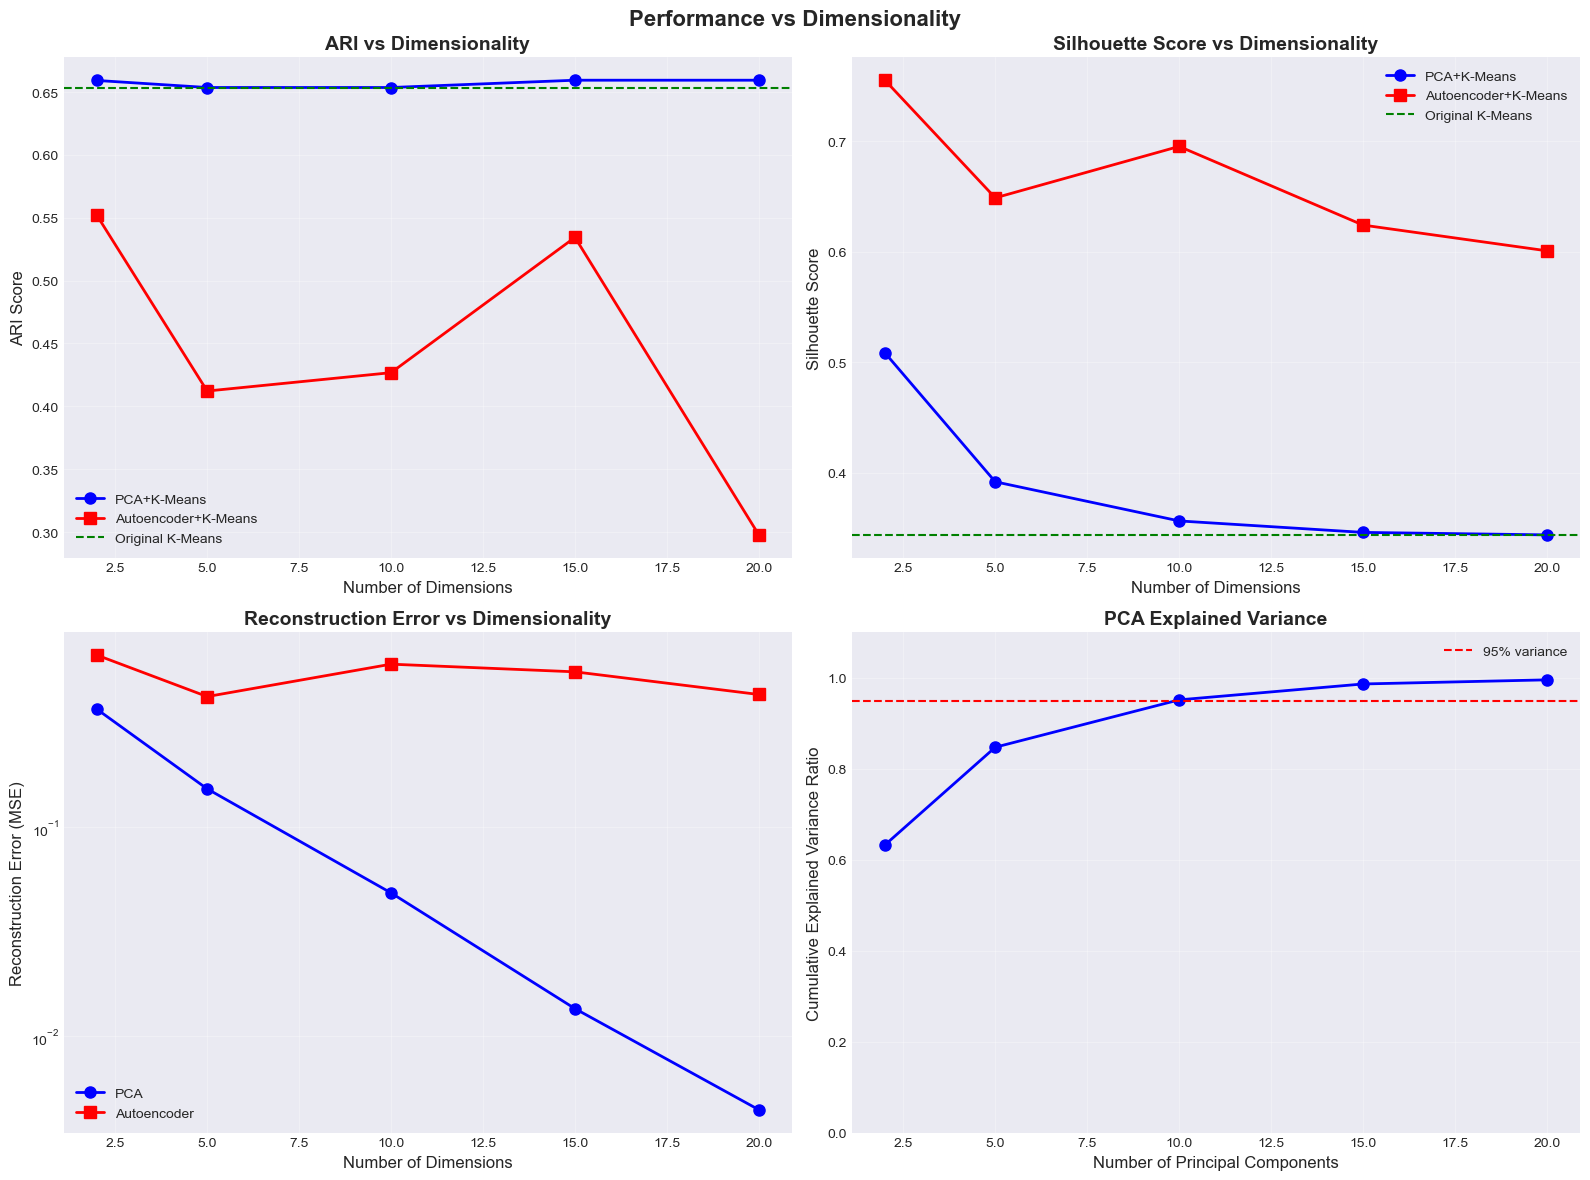

In [151]:
print("=" * 80)
print("ADDITIONAL VISUALIZATIONS")
print("=" * 80)

# Visualization: Reconstruction Error vs Clustering Performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Reconstruction Error vs Clustering Performance', fontsize=16, fontweight='bold')

# PCA: Reconstruction Error vs ARI
pca_dims_list = []
pca_recon_errors = []
pca_aris = []
for dim in pca_dims:
    if dim in exp3_results:
        pca_dims_list.append(dim)
        pca_recon_errors.append(exp3_results[dim]['reconstruction_error'])
        pca_aris.append(exp3_results[dim]['metrics']['ari'])

axes[0].scatter(pca_recon_errors, pca_aris, s=100, c=pca_dims_list, cmap='viridis', 
               edgecolors='black', linewidth=2, alpha=0.7)
for i, dim in enumerate(pca_dims_list):
    axes[0].annotate(f'{dim}D', (pca_recon_errors[i], pca_aris[i]), 
                    fontsize=10, ha='center', va='bottom')
axes[0].set_xlabel('Reconstruction Error (MSE)', fontsize=12)
axes[0].set_ylabel('ARI Score', fontsize=12)
axes[0].set_title('PCA: Reconstruction Error vs ARI', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(axes[0].collections[0], ax=axes[0], label='Dimensions')

# Autoencoder: Reconstruction Error vs ARI
ae_dims_list = []
ae_recon_errors = []
ae_aris = []
for dim in bottleneck_dims:
    if dim in exp5_results:
        ae_dims_list.append(dim)
        ae_recon_errors.append(exp5_results[dim]['reconstruction_error'])
        ae_aris.append(exp5_results[dim]['metrics']['ari'])

axes[1].scatter(ae_recon_errors, ae_aris, s=100, c=ae_dims_list, cmap='plasma', 
               edgecolors='black', linewidth=2, alpha=0.7, marker='s')
for i, dim in enumerate(ae_dims_list):
    axes[1].annotate(f'{dim}D', (ae_recon_errors[i], ae_aris[i]), 
                    fontsize=10, ha='center', va='bottom')
axes[1].set_xlabel('Reconstruction Error (MSE)', fontsize=12)
axes[1].set_ylabel('ARI Score', fontsize=12)
axes[1].set_title('Autoencoder: Reconstruction Error vs ARI', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(axes[1].collections[0], ax=axes[1], label='Dimensions')

plt.tight_layout()
plt.savefig('reconstruction_vs_clustering.png', dpi=300, bbox_inches='tight')
print("Saved: reconstruction_vs_clustering.png")
plt.show()

# Visualization: Dimensionality vs Performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performance vs Dimensionality', fontsize=16, fontweight='bold')

# ARI vs Dimension
axes[0, 0].plot(pca_dims_list, pca_aris, 'o-', linewidth=2, markersize=8, label='PCA+K-Means', color='blue')
axes[0, 0].plot(ae_dims_list, ae_aris, 's-', linewidth=2, markersize=8, label='Autoencoder+K-Means', color='red')
axes[0, 0].axhline(y=comprehensive_metrics['Exp1']['metrics']['ari'], color='green', 
                   linestyle='--', label='Original K-Means')
axes[0, 0].set_xlabel('Number of Dimensions', fontsize=12)
axes[0, 0].set_ylabel('ARI Score', fontsize=12)
axes[0, 0].set_title('ARI vs Dimensionality', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Silhouette vs Dimension
pca_sil = [comprehensive_metrics[f'Exp3_PCA_{dim}D']['metrics']['silhouette'] for dim in pca_dims_list]
ae_sil = [comprehensive_metrics[f'Exp5_AE_{dim}D']['metrics']['silhouette'] for dim in ae_dims_list]
axes[0, 1].plot(pca_dims_list, pca_sil, 'o-', linewidth=2, markersize=8, label='PCA+K-Means', color='blue')
axes[0, 1].plot(ae_dims_list, ae_sil, 's-', linewidth=2, markersize=8, label='Autoencoder+K-Means', color='red')
axes[0, 1].axhline(y=comprehensive_metrics['Exp1']['metrics']['silhouette'], color='green', 
                   linestyle='--', label='Original K-Means')
axes[0, 1].set_xlabel('Number of Dimensions', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score vs Dimensionality', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Reconstruction Error vs Dimension
axes[1, 0].plot(pca_dims_list, pca_recon_errors, 'o-', linewidth=2, markersize=8, label='PCA', color='blue')
axes[1, 0].plot(ae_dims_list, ae_recon_errors, 's-', linewidth=2, markersize=8, label='Autoencoder', color='red')
axes[1, 0].set_xlabel('Number of Dimensions', fontsize=12)
axes[1, 0].set_ylabel('Reconstruction Error (MSE)', fontsize=12)
axes[1, 0].set_title('Reconstruction Error vs Dimensionality', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_yscale('log')

# Explained Variance for PCA
pca_explained = [exp3_results[dim]['explained_variance'] for dim in pca_dims_list]
axes[1, 1].plot(pca_dims_list, pca_explained, 'o-', linewidth=2, markersize=8, color='blue')
axes[1, 1].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[1, 1].set_xlabel('Number of Principal Components', fontsize=12)
axes[1, 1].set_ylabel('Cumulative Explained Variance Ratio', fontsize=12)
axes[1, 1].set_title('PCA Explained Variance', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig('dimensionality_vs_performance.png', dpi=300, bbox_inches='tight')
print("Saved: dimensionality_vs_performance.png")
plt.show()


### Section 14: Final Summary and Conclusions

Provide final summary with key findings and conclusions from all experiments.


In [152]:
print("=" * 80)
print("FINAL SUMMARY AND CONCLUSIONS")
print("=" * 80)

print("\n1. Key Findings:")
print("-" * 80)

# Find best overall method
best_overall = comparison_df.loc[comparison_df['ARI'].idxmax()]
print(f"\n   Best Overall Method (by ARI):")
print(f"     {best_overall['Experiment']}: {best_overall['Method']} + {best_overall['Dim Reduction']} ({best_overall['Dimension']}D)")
print(f"     ARI: {best_overall['ARI']:.4f}, Silhouette: {best_overall['Silhouette']:.4f}")

print(f"\n   Dimensionality Reduction Comparison:")
pca_avg_ari = comparison_df[comparison_df['Dim Reduction'] == 'PCA']['ARI'].mean()
ae_avg_ari = comparison_df[comparison_df['Dim Reduction'] == 'Autoencoder']['ARI'].mean()
print(f"     Average ARI - PCA: {pca_avg_ari:.4f}")
print(f"     Average ARI - Autoencoder: {ae_avg_ari:.4f}")
if pca_avg_ari > ae_avg_ari:
    print(f"     Conclusion: PCA performs better on average")
else:
    print(f"     Conclusion: Autoencoder performs better on average")

print(f"\n   Clustering Method Comparison:")
kmeans_avg_ari = comparison_df[comparison_df['Method'] == 'K-Means']['ARI'].mean()
gmm_avg_ari = comparison_df[comparison_df['Method'].str.contains('GMM')]['ARI'].mean()
print(f"     Average ARI - K-Means: {kmeans_avg_ari:.4f}")
print(f"     Average ARI - GMM: {gmm_avg_ari:.4f}")

print(f"\n   Optimal Dimensionality:")
reduced_df = comparison_df[comparison_df['Dim Reduction'] != 'None'].copy()
best_dim_idx = reduced_df['ARI'].idxmax()
best_dim = reduced_df.loc[best_dim_idx]
print(f"     Best dimension: {best_dim['Dimension']}D")
print(f"     Method: {best_dim['Method']} + {best_dim['Dim Reduction']}")
print(f"     ARI: {best_dim['ARI']:.4f}")

print("\n2. Trade-offs Identified:")
print("-" * 80)
print("   - Lower dimensionality → Lower reconstruction error but may reduce clustering quality")
print("   - PCA provides interpretable components with explained variance")
print("   - Autoencoder can capture non-linear relationships but requires more training time")
print("   - GMM provides probabilistic assignments but is computationally more expensive")
print("   - K-Means is faster but assumes spherical clusters")

print("\n3. Recommendations:")
print("-" * 80)
print("   - For this dataset, optimal dimensionality appears to be around 5-10 dimensions")
print("   - PCA is recommended for faster processing and interpretability")
print("   - GMM with appropriate covariance type can capture cluster shapes better")
print("   - Consider computational constraints when choosing between methods")

print("\n" + "=" * 80)
print("PART 3: EVALUATION AND ANALYSIS COMPLETE!")
print("=" * 80)
print("\nAll visualizations saved:")
print("  - 2d_projections.png")
print("  - elbow_curves.png")
print("  - bic_aic_curves.png")
print("  - autoencoder_training_curves.png")
print("  - cluster_assignments_2d.png")
print("  - comparison_heatmap.png")
print("  - confusion_matrices.png")
print("  - reconstruction_vs_clustering.png")
print("  - dimensionality_vs_performance.png")
print("\nData saved:")
print("  - comprehensive_comparison.csv")
print("=" * 80)


FINAL SUMMARY AND CONCLUSIONS

1. Key Findings:
--------------------------------------------------------------------------------

   Best Overall Method (by ARI):
     Exp3_PCA_15D: K-Means + PCA (15D)
     ARI: 0.6594, Silhouette: 0.3461

   Dimensionality Reduction Comparison:
     Average ARI - PCA: 0.4974
     Average ARI - Autoencoder: 0.3587
     Conclusion: PCA performs better on average

   Clustering Method Comparison:
     Average ARI - K-Means: 0.5602
     Average ARI - GMM: 0.3208

   Optimal Dimensionality:
     Best dimension: 15D
     Method: K-Means + PCA
     ARI: 0.6594

2. Trade-offs Identified:
--------------------------------------------------------------------------------
   - Lower dimensionality → Lower reconstruction error but may reduce clustering quality
   - PCA provides interpretable components with explained variance
   - Autoencoder can capture non-linear relationships but requires more training time
   - GMM provides probabilistic assignments but is comp